# Анализ данных по видеоиграм

**Задача:** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>
**Данные** Из открытых источников доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы<br>

<h2>Описание данных</h2><div class="paragraph">Таблица <code class="code-inline code-inline_theme_light">users</code> (информация о пользователях):</div><ul><li><em>Name</em> — название игры</li><li><em>Platform</em> — платформа</li><li><em>Year_of_Release</em> — год выпуска</li><li><em>Genre</em> — жанр игры</li><li><em>NA_sales —</em> продажи в Северной Америке (миллионы проданных копий)</li><li><em>EU_sales</em> — продажи в Европе (миллионы проданных копий)</li><li><em>JP_sales</em> — продажи в Японии (миллионы проданных копий)</li><li><em>Other_sales —</em> продажи в других странах (миллионы проданных копий)</li><li><em>Critic_Score</em> — оценка критиков (максимум 100)</li><li><em>User_Score</em> — оценка пользователей (максимум 10)</li><li><em>Rating</em> — рейтинг от организации <em>ESRB</em> (англ. <em>Entertainment Software Rating Board).</em> Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.</li></ul>
 
Данные за 2016 год могут быть неполными.

## Шаг 1. Изучение данных из файлов

In [112]:
from pylab import rcParams
rcParams['figure.figsize'] = (9,6)

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2")

import numpy as np
from scipy import stats as st
from scipy import interpolate as itpl

import seaborn as sns
sns.set_style("whitegrid", {'figure.facecolor': '0.97',})
sns.set_palette("Set2")

<Figure size 648x432 with 0 Axes>

In [113]:
if False:
    import pandas_profiling
    df.profile_report()

In [114]:
try:
    df = pd.read_csv('/datasets/games.csv', sep=',')
except:
    df = pd.read_csv('datasets\yandex_cp1_games.csv', sep=',')


In [115]:
#сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    #mask = np.zeros_like(corr)
    #mask[np.triu_indices_from(mask)] = True
    mask=np.triu(np.full(corr.shape, True))
    corr=corr.iloc[1:,:-1]
    mask=pd.DataFrame(mask).iloc[1:,:-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize = (corr.shape[0]*1.2,(corr.shape[0]*0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_na_plots = False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_na_plots:
        # готовим матрицу корреляций пропусков
        t = df.isna().sum().sort_values()
        indx = t[t>0].index
        if len(indx)>0:
            print()
            corr=df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NaN in columns")
            
            # Добавим карту синхронных пропусков
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NaN values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs()+0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())

In [116]:
def evaluate_column(df, col, max_unique_values=100):
    print('-------  INFO: column ' + col + '   ---------')
    print("col type:", df[col].dtypes, sep="\t")
    print("count notNA:", df[col].notna().sum(), sep="\t")
    
    print(f"count NA:\t{df[col].isna().sum():.0f}\t({df[col].isna().mean():.2%})")
    print("count ZEROs:", df[col].isin([0,'0']).sum(), sep="\t")

    print("count unique:", len(df[col].unique()), sep="\t")
   
    print('\n\n-------  frequent values   ---------')
    print(df[col].value_counts().to_frame(name='count').head(10))
    
    print('\n\n-------  len values   ---------')
    print(df[col].astype('str').str.len().value_counts().to_frame(name='count').head(10))
    
    print('\n\n-------  datatypes in column ' + col + '   ---------')
    print(df[col].apply(type).value_counts().to_frame(name='count'))
    
    print('\n\n-------  unique values   ---------')
    print(df[col].sort_values().unique()[:max_unique_values])

### Изучение DataFrame


------SAMPLE--------


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14649,NBA 08,PSP,"2,007.000",Sports,0.030,0.000,0.000,0.000,75.000,7.5,E
15365,The Sims: Complete Collection,PC,"2,005.000",Simulation,0.010,0.010,0.000,0.000,NaN,NaN,NaN
5285,Homefront: The Revolution,PS4,"2,016.000",Shooter,0.060,0.210,0.030,0.050,48.000,3.8,M
3828,F1 2009,PSP,"2,009.000",Racing,0.080,0.290,0.000,0.160,68.000,7.2,E
10260,Backyard NFL Football '10,X360,"2,009.000",Sports,0.100,0.000,0.000,0.010,NaN,NaN,NaN



------DTYPES--------
Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object


------NaN & zero--------
                   NA  filled   zero    %na
Name                2   16713      -  0.012
Platform            -   16715      -      -
Year_of_Release   269   16446      -  1.609
Genre               2   16713      -  0.012
NA_sales            -   16715   4508      -
EU_sales            -   16715   5870      -
JP_sales            -   16715  10514      -
Other_sales         -   16715   6601      -
Critic_Score     8578    8137      - 51.319
User_Score       6701   10014      1 40.090
Rating           6766    9949      - 40.479



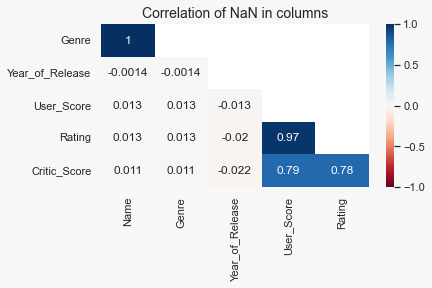

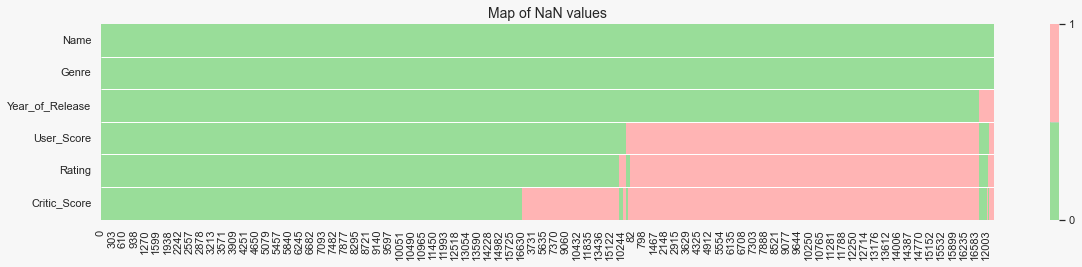

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,16713,11559,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform,16715,31,PS2,2161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year_of_Release,"16,446.000",NaN,NaN,NaN,"2,006.485",5.877,"1,980.000","2,003.000","2,007.000","2,010.000","2,016.000"
Genre,16713,12,Action,3369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_sales,"16,715.000",NaN,NaN,NaN,0.263,0.814,0.000,0.000,0.080,0.240,41.360
EU_sales,"16,715.000",NaN,NaN,NaN,0.145,0.503,0.000,0.000,0.020,0.110,28.960
JP_sales,"16,715.000",NaN,NaN,NaN,0.078,0.309,0.000,0.000,0.000,0.040,10.220
Other_sales,"16,715.000",NaN,NaN,NaN,0.047,0.187,0.000,0.000,0.010,0.030,10.570
Critic_Score,"8,137.000",NaN,NaN,NaN,68.968,13.938,13.000,60.000,71.000,79.000,98.000
User_Score,10014,96,tbd,2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
evaluate_df(df, True)

### Проверим нет ли дубликатов

Мы в дальнейших обработках будем использовать имена игр и нужно проверить нет ли там дубликатов по названию, отличающихся только регистром. Посчитаем число уникальных без учета регистра и с учетом:

In [118]:
len(df['Name'].unique())

11560

In [119]:
len(df['Name'].str.lower().unique())

11560

Дубликатов нет в названиях

Проверим названия платформ, жанров, рейтингов

In [120]:
df['Platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [121]:
df['Genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

In [122]:
df['Rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

**Выводы**<br>
- Названия столбцов не snake_case
- Есть пропуски в шести столбцах
- Year_of_Release нужно сделать int (если NA убрать или заменить получится)
- Датасет содержит старые игры (с 1980г)
- Очень много пропусков Critic_Score, User_Score, Rating
- User_Score имеет тип object вместо float
- User_Score содержит текстовое значение tbd. В столбце смесь чисел в виде текста, буквенных значений и пропусков
- нет неявных дубликатов в столбцах Name, Platform, Genre, Rating
- Регионы продаж имеют много игр с нулевыми продажами в регионе. Возможно это региональные игры, но возможно пустые строки с нулевыми продажами (или менее 0,01 млн шт)
- Есть одна строка с рейтингом пользователей 0. Возможно ошибка, возможно это ок. Нужно проверить

## Шаг 2. Подготовка данных

### Приведение типов и исправление ошибок

In [123]:
# переименование колонок
df.columns = df.columns.str.lower()

#### обработка name

In [124]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.000",NaN,1.780,0.530,0.000,0.080,NaN,NaN,NaN
14244,NaN,GEN,"1,993.000",NaN,0.000,0.000,0.030,0.000,NaN,NaN,NaN


In [125]:
len(df.query('name=="NULL_name"'))

0

Заменим пропуски на "NULL_name"

In [126]:
# замена нулей
df.loc[df['name'].isna(),'name'] = "NULL_name"

Вообще, есть подозрение, что это одна игра, задублированная в 2 строки. Продажи Японии в строке 659 отсутствуют, а в строке 14244 нет никаких продаж, зато есть JP. платформа, имя, год совпадают

#### обработка user_score
User_Score содержит текстовое значение tbd. Google говорит что это аббревиатура tbd = To Be determined. По сути, NA это.
Смотрим нет ли еще текстовых величин, которые не получится преобразовать в float

In [127]:
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [128]:
# Заменим 'tbd' на NaN и переведем столбец в float
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Посмотрим общие статистики теперь

In [129]:
df['user_score'].describe()

count   7,590.000
mean        7.125
std         1.500
min         0.000
25%         6.400
50%         7.500
75%         8.200
max         9.700
Name: user_score, dtype: float64

Странно, видна оценка 0. Посмотрим гистограмму

<AxesSubplot:>

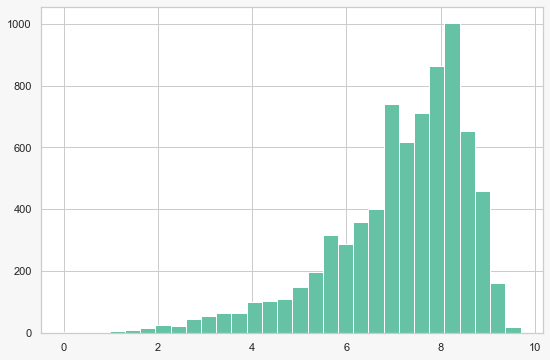

In [130]:
df['user_score'].hist(bins=30)

Вроде норм, просто какие-то игры не смогли найти свою аудиторию и их плохо оценили

#### Проверка жанров

В данных было два пропуска жанра. Заменим на "Прочее" чтобы не удалять строки. Это почти не повлияет на общую картину, но сохраним данные

In [131]:
# замена нулей
df.loc[df['genre'].isna(),'genre'] = "Misc"

#### Пропуски critic_score, user_score, rating

При знакомстве с данными было видно, что 'critic_score', 'user_score', 'rating' имеют много пропусков.<br>
Посмотрим случайны ли они или проявляются одновременно.<br>

Чтобы было нагляднее, сделаем heatmap (NaN желтый, неNaN синий)

<AxesSubplot:>

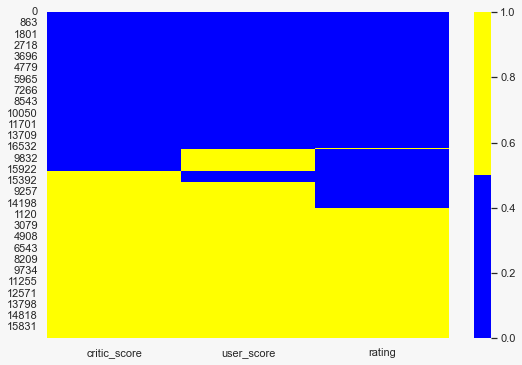

In [132]:
t = df[[ 'critic_score', 'user_score', 'rating']].isnull().sort_values(by=['critic_score', 'user_score', 'rating'])
sns.heatmap(t, cmap=sns.color_palette(['#0000FF', '#ffff00'] ))


------SAMPLE--------


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
9101,The Da Vinci Code,PS2,"2,006.000",Action,0.070,0.050,0.000,0.020,54.000,8.000,T
14631,Romance of the Three Kingdoms II,3DS,"2,015.000",Strategy,0.000,0.000,0.030,0.000,NaN,NaN,NaN
4663,Tomb Raider: The Last Revelation,PC,"1,998.000",Action,0.410,0.000,0.000,0.000,NaN,8.600,T
16415,Really? Really! DS,DS,"2,009.000",Adventure,0.000,0.000,0.010,0.000,NaN,NaN,NaN
13335,Soul Eater: Plot of Medusa,DS,"2,008.000",Action,0.000,0.000,0.050,0.000,NaN,NaN,NaN



------DTYPES--------
name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object


------NaN & zero--------
                   NA  filled   zero    %na
name                -   16715      -      -
platform            -   16715      -      -
year_of_release   269   16446      -  1.609
genre               -   16715      -      -
na_sales            -   16715   4508      -
eu_sales            -   16715   5870      -
jp_sales            -   16715  10514      -
other_sales         -   16715   6601      -
critic_score     8578    8137      - 51.319
user_score       9125    7590      1 54.592
rating           6766    9949      - 40.479



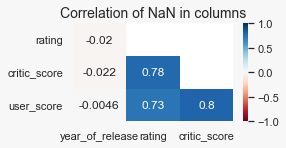

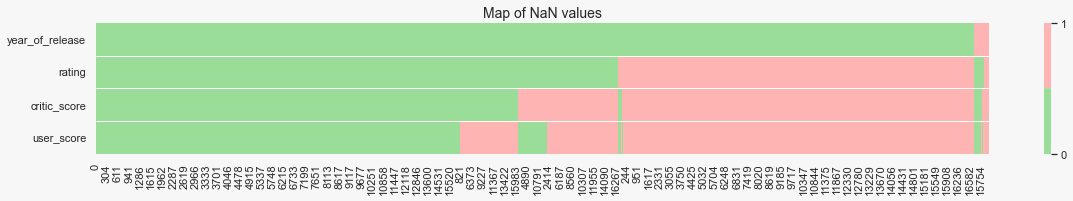

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,16715,11560,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
platform,16715,31,PS2,2161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_of_release,"16,446.000",NaN,NaN,NaN,"2,006.485",5.877,"1,980.000","2,003.000","2,007.000","2,010.000","2,016.000"
genre,16715,12,Action,3369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
na_sales,"16,715.000",NaN,NaN,NaN,0.263,0.814,0.000,0.000,0.080,0.240,41.360
eu_sales,"16,715.000",NaN,NaN,NaN,0.145,0.503,0.000,0.000,0.020,0.110,28.960
jp_sales,"16,715.000",NaN,NaN,NaN,0.078,0.309,0.000,0.000,0.000,0.040,10.220
other_sales,"16,715.000",NaN,NaN,NaN,0.047,0.187,0.000,0.000,0.010,0.030,10.570
critic_score,"8,137.000",NaN,NaN,NaN,68.968,13.938,13.000,60.000,71.000,79.000,98.000
user_score,"7,590.000",NaN,NaN,NaN,7.125,1.500,0.000,6.400,7.500,8.200,9.700


In [133]:
evaluate_df(df, True)

Видно, что пропуски не случайны. <br>
Больша'я часть игр просто не оценена вообще ни критиками ни пользователями и без рейтинга.<br>
Возможно это ошибка при слиянии разных баз данных

Думаю восстановить оценки критиков мы не сможем.

Сделаем вспомогательный столбец CUR, содержащий признак пропуска в каждом из '<b>C</b>ritic_score', '<b>U</b>ser_score', '<b>R</b>ating'<br>
Например, 111 значит нет нигде пропуска, а 000 значит все три столбца с пропуском

In [134]:
df['cur'] = df['critic_score'].notna().astype(int).astype(str)\
+ df['user_score'].notna().astype(int).astype(str)\
+ df['rating'].notna().astype(int).astype(str)

#### Обработка rating

Изучим какие рейтинги стоят в столбце

In [135]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Из описания рейтингов видеоигр
https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board
- «EC» («Early childhood») 3+
- «E» («Everyone») 6+
- «E10+» («Everyone 10 and older») 10+
- «T» («Teen») 13+
- «M» («Mature») — «Для взрослых» 17+
- «AO» («Adults Only 18+») 18+
- «RP» («Rating Pending») NA
- «K-A» ("Kids to Adults") это старое название «E» («Everyone»)

Сделаем замены:
- замену NaN -> RP сделаем позже, после попытки частичного восстановления рейтингов
- K-A -> E
- AO -> M (чтобы одна единственная запись потом не мешала анализировать влияние рейтинга на продажи)

In [136]:
# замены

df['rating'] = df['rating'].where(df['rating'] != 'K-A', 'E')
df['rating'] = df['rating'].where(df['rating'] != 'AO', 'M')

# проверка
df['rating'].value_counts()

E       3993
T       2961
M       1564
E10+    1420
EC         8
RP         3
Name: rating, dtype: int64

### Расчеты дополнительных полей

In [137]:
# добавим столбец с общими продажами по всем регионам
df['total_sales'] = df.loc[:,'na_sales':'other_sales'].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cur,total_sales
0,Wii Sports,Wii,"2,006.000",Sports,41.360,28.960,3.770,8.450,76.000,8.000,E,111,82.540
1,Super Mario Bros.,NES,"1,985.000",Platform,29.080,3.580,6.810,0.770,NaN,NaN,NaN,000,40.240
2,Mario Kart Wii,Wii,"2,008.000",Racing,15.680,12.760,3.790,3.290,82.000,8.300,E,111,35.520
3,Wii Sports Resort,Wii,"2,009.000",Sports,15.610,10.930,3.280,2.950,80.000,8.000,E,111,32.770
4,Pokemon Red/Pokemon Blue,GB,"1,996.000",Role-Playing,11.270,8.890,10.220,1.000,NaN,NaN,NaN,000,31.380


### Проверка исправленных типов и наличия дубликатов

In [138]:
# выводим все столбцы всех датафреймов и их типы
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
cur                 object
total_sales        float64
dtype: object

Все хорошо, типы правильные теперь, пропуски проанализировали

Посмотрим дубликаты еще

### Проверка дубликатов

In [139]:
# проверка дубликатов
if df.duplicated().sum() == 0:
    print(f'Дублей полных нет (0)')
else:
    print(f'Дубли полные ЕСТЬ ({df.duplicated().sum()})')

Дублей полных нет (0)


Проверим еще дубли по ключу Название+Платформа+Год

In [140]:
sub = ['name', 'platform', 'year_of_release']


if df.duplicated(subset=sub).sum() ==0:
    print(f'Дублей частичных нет (0)')
else:
    print(f'Дубли частичные ЕСТЬ ({df.duplicated(subset=sub).sum()})')
    display(
        df[df.duplicated(subset=sub, keep=False)].sort_values(by=sub)
    )

Дубли частичные ЕСТЬ (2)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cur,total_sales
604,Madden NFL 13,PS3,"2,012.000",Sports,2.110,0.220,0.000,0.230,83.000,5.500,E,111,2.560
16230,Madden NFL 13,PS3,"2,012.000",Sports,0.000,0.010,0.000,0.000,83.000,5.500,E,111,0.010
659,NULL_name,GEN,"1,993.000",Misc,1.780,0.530,0.000,0.080,NaN,NaN,NaN,000,2.390
14244,NULL_name,GEN,"1,993.000",Misc,0.000,0.000,0.030,0.000,NaN,NaN,NaN,000,0.030


NULL_name и Madden NFL 13 похожи на дубликаты 

- NULL_name имеет две строки, дополняющие друг друга по регионам
- Madden NFL 13 имеет две строки, совпадающие по имени, году, жанру, оценке критиков, оценке пользователей, рейтингу

Судя по объемам продаж, дублями являются вторые строки (с бОльшим индексом). Уберем их

In [141]:
# Убираем дубли вторые
df = df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first').reset_index(drop=True)

# проверяем что дублей нет
df.duplicated(subset=sub).sum()

0

## Шаг 2.2 Дополнительные проверки

### Проверка genre

Проверим, всегда ли у одного названия один жанр

In [142]:
t = df[['name', 'genre']].drop_duplicates().groupby(by='name').count()
t.query('genre > 1')

,genre
name,
Battlezone,2
Culdcept,2
Little Busters! Converted Edition,2
Steins;Gate: Hiyoku Renri no Darling,2
Syndicate,2


Оказалось есть 5 игр, которые характеризуются двумя жанрами. посмотрим на них поподробнее

In [143]:
lst = list(t.query('genre > 1').reset_index()['name'])
df.query('name in @lst').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cur,total_sales
3231,Battlezone,2600,"1,982.000",Shooter,0.580,0.030,0.000,0.010,NaN,NaN,NaN,000,0.620
13549,Battlezone,PS4,"2,016.000",Action,0.020,0.020,0.000,0.010,66.000,7.000,T,111,0.050
14878,Battlezone,PSP,"2,006.000",Shooter,0.020,0.000,0.000,0.000,57.000,NaN,E10+,101,0.020
8662,Culdcept,3DS,"2,012.000",Misc,0.000,0.000,0.160,0.000,NaN,NaN,NaN,000,0.160
14632,Culdcept,PS2,"2,002.000",Strategy,0.010,0.010,0.000,0.000,78.000,8.900,T,111,0.020
13089,Little Busters! Converted Edition,PS2,"2,009.000",Adventure,0.000,0.000,0.050,0.000,NaN,NaN,NaN,000,0.050
13705,Little Busters! Converted Edition,PSP,"2,010.000",Adventure,0.000,0.000,0.040,0.000,NaN,NaN,NaN,000,0.040
14934,Little Busters! Converted Edition,PSV,"2,012.000",Action,0.000,0.000,0.030,0.000,NaN,NaN,NaN,000,0.030
11461,Steins;Gate: Hiyoku Renri no Darling,X360,"2,011.000",Adventure,0.000,0.000,0.080,0.000,NaN,NaN,NaN,000,0.080
12652,Steins;Gate: Hiyoku Renri no Darling,PSP,"2,012.000",Action,0.000,0.000,0.060,0.000,NaN,NaN,NaN,000,0.060


По всей видимости, некоторые из них это осовремененные игры 80х, произошла смена жанра даже. 
https://en.wikipedia.org/wiki/List_of_video_game_genres

- Судя по википедии Action это группа жанров, которая включает в себя Shooter, поэтому Battlezone PS4 это Shooter
- Culdcept 3DS это не Misc а Strategy судя по Google
- Little Busters! Converted Edition	PSV это не Action а Adventure (в поджанре Visual novel)
- Steins;Gate: Hiyoku Renri no Darling	это не Action а Adventure (в поджанре Visual novel)

а вот Syndicate на PC это реально Strategy, которая потом стала Shooter. Тут действительно 2 жанра разных

Сделаем замены:

In [144]:
#создадим словарь замен
mapping = {
            'Battlezone': 'Shooter'
            , 'Culdcept': 'Strategy'
            , 'Little Busters! Converted Edition': 'Adventure'
            , 'Steins;Gate: Hiyoku Renri no Darling': 'Adventure'
          }
# делаем замены
for k,v in mapping.items():
    df['genre'] = df['genre'].where(df['name'] != k, v)

# проверим как прошли замены
df.query('name in @lst').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cur,total_sales
3231,Battlezone,2600,"1,982.000",Shooter,0.580,0.030,0.000,0.010,NaN,NaN,NaN,000,0.620
13549,Battlezone,PS4,"2,016.000",Shooter,0.020,0.020,0.000,0.010,66.000,7.000,T,111,0.050
14878,Battlezone,PSP,"2,006.000",Shooter,0.020,0.000,0.000,0.000,57.000,NaN,E10+,101,0.020
8662,Culdcept,3DS,"2,012.000",Strategy,0.000,0.000,0.160,0.000,NaN,NaN,NaN,000,0.160
14632,Culdcept,PS2,"2,002.000",Strategy,0.010,0.010,0.000,0.000,78.000,8.900,T,111,0.020
13089,Little Busters! Converted Edition,PS2,"2,009.000",Adventure,0.000,0.000,0.050,0.000,NaN,NaN,NaN,000,0.050
13705,Little Busters! Converted Edition,PSP,"2,010.000",Adventure,0.000,0.000,0.040,0.000,NaN,NaN,NaN,000,0.040
14934,Little Busters! Converted Edition,PSV,"2,012.000",Adventure,0.000,0.000,0.030,0.000,NaN,NaN,NaN,000,0.030
11461,Steins;Gate: Hiyoku Renri no Darling,X360,"2,011.000",Adventure,0.000,0.000,0.080,0.000,NaN,NaN,NaN,000,0.080
12652,Steins;Gate: Hiyoku Renri no Darling,PSP,"2,012.000",Adventure,0.000,0.000,0.060,0.000,NaN,NaN,NaN,000,0.060


Все хорошо

### Обработка year_of_release

Если год выпуска не заполнен, то год выпуска игры можно взять как минимум года выпуска той же игры но на других платформах

Платформы появлялись в разные года. Какие-то раньше, а какие-то позже. При установке года выпуска игры нелья ставить год раньше чем сама платформа появилась
Добавим колонку с годом игры данного жанра
Также добавим колонку с годом первой игры платформы

In [145]:
print('Пропусков до начала обработки year_of_release\n', df['year_of_release'].isna().sum())

Пропусков до начала обработки year_of_release
 269


In [146]:
# добавим колонку с годом первой игры платформы
df['year_platform'] = df.groupby(['platform'])['year_of_release'].transform('min')

# Добавим колонку с годом игры данного жанра на других платформах
df['year_game'] = df.groupby(['name', 'genre'])['year_of_release'].transform('min')

df[['year_game','year_platform']].isna().sum()

year_game        146
year_platform      0
dtype: int64

Заполним year_of_release = max(year_platform, year_game)

In [147]:
df['year_of_release'] = df['year_of_release'].where(
    (df['year_of_release'] == df['year_of_release'])|(df['year_game'].isna()),\
    df[['year_platform', 'year_game']].max(axis=1))

Проверим

In [148]:
df['year_of_release'].isna().sum()

146

В названиях игр часто встречаются года. Посмотрим, возможно мы их сможем использовать для восстановления года выпуска игры

In [149]:
list(df[df['year_of_release'].isna()]['name'])

['wwe Smackdown vs. Raw 2006',
 'Rock Band',
 "Frogger's Adventures: Temple of the Frog",
 'Rock Band',
 'Rock Band',
 'Triple Play 99',
 'Adventure',
 'Combat',
 'Rock Band',
 'Legacy of Kain: Soul Reaver',
 'Donkey Kong Land III',
 'Air-Sea Battle',
 'Suikoden III',
 'Yakuza 4',
 'WarioWare: Twisted!',
 'Test Drive Unlimited 2',
 'Monster Hunter 2',
 'Test Drive Unlimited 2',
 'Advance Wars: Days of Ruin',
 'Fishing Derby',
 'Karate',
 'Circus Atari',
 'The Chronicles of Riddick: Escape from Butcher Bay',
 "Maze Craze: A Game of Cops 'n Robbers",
 'Silent Hill: Homecoming',
 'Super Breakout',
 "Robert Ludlum's The Bourne Conspiracy",
 'NHL Slapshot',
 'TERA',
 'NFL GameDay 2003',
 'Harvest Moon: Save the Homeland',
 "Robert Ludlum's The Bourne Conspiracy",
 'Silent Hill: Homecoming',
 'Hangman',
 "Cubix Robots for Everyone: Clash 'n' Bash",
 'Dragon Ball Z: Budokai Tenkaichi 2 (JP sales)',
 'Dragster',
 'All-Star Baseball 2005',
 'Slot Machine',
 'The Dukes of Hazzard II: Daisy Dukes

Да, около 7 игр имеют в названии в конце год (2003...2011)

Сделаем функцию, которая обработает названия и запишет год создания

In [150]:
def set_year_from_name(row):
    if row[2] != row[2]:
        year=0
        name = row[0]
        last_word = name[-4:]
        if last_word.isnumeric():
            if int(last_word)>2000:
                year = int(last_word)
                row[2] = year
                print('успех')
    return row

In [151]:
# делаем обработку
df = df.apply(set_year_from_name, axis=1)

успех
успех
успех
успех
успех
успех
успех


In [152]:
df['year_of_release'].isna().sum()

139

Будем считать что 139 из 16713 (0.8%) будет пустых на удаление

И преобразуем тип в int

In [153]:
# удалим строки с нулями
df = df.dropna(subset=['year_of_release'])

# заменим тип на INT
df['year_of_release'] = df['year_of_release'].astype('int')

### Обработка пропусков rating

Ранее мы определили категории cur в которых отображалось имеется ли пропуск в столбцах 'critic_score', 'user_score', 'rating'
Посмотрим как изменялись продажи у игр с пропусками и без по годам

Категория CUR это признак заполненности оценки Критиков, Пользователей и наличие рейтинга. cur='111' значит все три поля заполнены, cur='000' означает, что все три поля не заполнены.

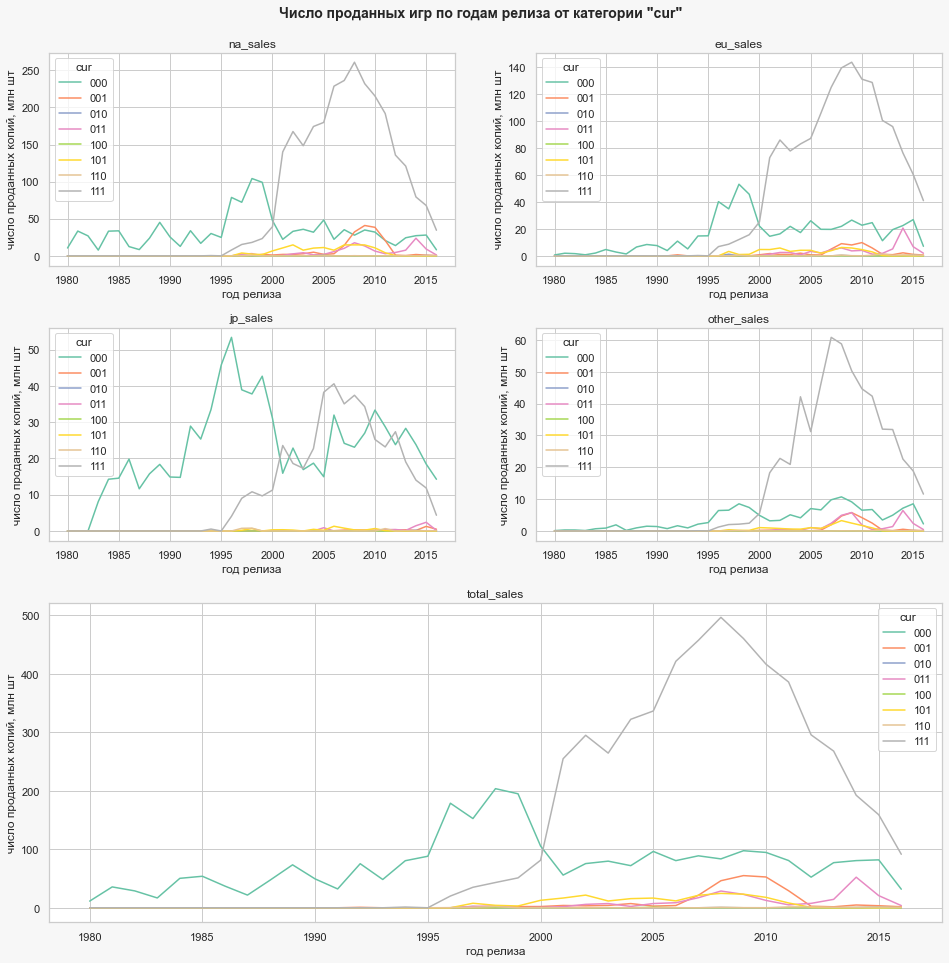

In [154]:
reg_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,16), gridspec_kw={'height_ratios': [1, 1, 1.5], 'hspace':0.25})

for i in range(4):
    r = i // 2 
    c = i % 2
    t = df.query('year_of_release>0')\
        .pivot_table(index='year_of_release', columns='cur', values=reg_list[i], aggfunc=sum).fillna(0)
    t.plot(kind='line', ax = ax[r,c]
           , title=reg_list[i]
          )
    ax[r,c].set_xlabel("год релиза")
    ax[r,c].set_ylabel("число проданных копий, млн шт")
gs = ax[2, 0].get_gridspec()
ax[-1,0].remove()
ax[-1,1].remove()
axbig = fig.add_subplot(gs[2, :])


t = df.query('year_of_release>0')\
        .pivot_table(index='year_of_release', columns='cur', values='total_sales', aggfunc=sum).fillna(0)
t.plot(kind='line'
       , ax = axbig
       , title='total_sales'
      );
axbig.set_xlabel("год релиза")
axbig.set_ylabel("число проданных копий, млн шт")


# title="Число проданных игр по годам релиза от категории \"cur\""
fig.suptitle("Число проданных игр по годам релиза от категории \"cur\"", x=0.5, y=0.92, fontsize=14, fontweight='bold')

plt.show();
plt.close('all')

Оказалось, что Торговая ассоциация ESRB была основана только в 1994 году, как и первая версия ее рейтингов. Вероятно поэтому часть популярных игр оказалась без рейтинга. Оценки и рейтинги начали массово появляться после 1997. Единичные оценки и рейтинги есть и до 1995, но скорее как исключение.

Обращает на себя внимание регион JP, у которого после 1994 высокая доля продаж игр без рейтинга, без оценок критиков и игроков.

Но часть пропусков можно попробовать восстановить.
Рейтинг это характеристика игры и их можно попробовать восстановить по соответствию с именем игры + жанра (помним про игру Syndicate). 

Также у одной пары игры + жанр на разных платформах может быть разные рейтинги, в этом случае пропуск заполним любым из рейтингов на других платформах


In [155]:
# делаем вспомогательную таблицу 
t = df[['name', 'genre', 'rating']].dropna().drop_duplicates().groupby(by=['name', 'genre']).first().reset_index()
t.columns = ['name', 'genre', 'rating_y']

# Join ее
df = df.merge(t, on=['name', 'genre'], how='left')

In [156]:
bf = df['rating'].isna().sum()
df['rating'] = df['rating'].where(df['rating'].notna(), df['rating_y'])
print('до замены было', bf, 'пропусков\nпосле замены', df['rating'].isna().sum(), 'пропусков')


до замены было 6704 пропусков
после замены 6268 пропусков


Есть небольшой эффект. Больше восстановить не получится. Заменим пропуски оставшиеся на "RP"

In [157]:
df['rating'] = df['rating'].fillna('RP')

In [158]:
# Удалим временные столбцы
df = df.drop(['year_platform', 'year_game', 'rating_y'], axis=1)

# проверим что теперь с датафреймом
evaluate_df(df)


------SAMPLE--------


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cur,total_sales
7431,Blue Dragon Plus,DS,2008,Role-Playing,0.120,0.030,0.050,0.010,69.000,6.500,E,111,0.210
12881,Arcania: Gothic 4,PS4,2015,Role-Playing,0.040,0.000,0.000,0.010,NaN,NaN,T,000,0.050
1776,WWE 2K14,PS3,2013,Sports,0.490,0.460,0.000,0.190,74.000,7.500,T,111,1.140
6352,Duel Masters,PS2,2004,Strategy,0.130,0.100,0.000,0.030,66.000,8.300,E,111,0.260
1686,Pro Evolution Soccer 2008,Wii,2008,Sports,0.090,0.840,0.110,0.150,83.000,8.400,E,111,1.190



------DTYPES--------
name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
cur                 object
total_sales        float64
dtype: object


------NaN & zero--------
                   NA  filled   zero    %na
name                -   16574      -      -
platform            -   16574      -      -
year_of_release     -   16574      -      -
genre               -   16574      -      -
na_sales            -   16574   4470      -
eu_sales            -   16574   5801      -
jp_sales            -   16574  10413      -
other_sales         -   16574   6528      -
critic_score     8496    8078      - 51.261
user_score       9032    7542      1 54.495
rating              -   16574      -      -
cur                 -   16574      -      -
total_sales   

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,16574,11433,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
platform,16574,31,PS2,2144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_of_release,"16,574.000",NaN,NaN,NaN,"2,006.489",5.863,"1,980.000","2,003.000","2,007.000","2,010.000","2,016.000"
genre,16574,12,Action,3339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
na_sales,"16,574.000",NaN,NaN,NaN,0.264,0.816,0.000,0.000,0.080,0.240,41.360
eu_sales,"16,574.000",NaN,NaN,NaN,0.146,0.505,0.000,0.000,0.020,0.110,28.960
jp_sales,"16,574.000",NaN,NaN,NaN,0.078,0.310,0.000,0.000,0.000,0.040,10.220
other_sales,"16,574.000",NaN,NaN,NaN,0.048,0.187,0.000,0.000,0.010,0.030,10.570
critic_score,"8,078.000",NaN,NaN,NaN,68.987,13.923,13.000,60.000,71.000,79.000,98.000
user_score,"7,542.000",NaN,NaN,NaN,7.126,1.498,0.000,6.400,7.500,8.200,9.700


  ### Итоги
  
  - названия столбцов сделали в snake_case
  - год преобразовали в int
  - заполнили пропуски в name, genre
  - определили год выпуска для 130 из 269 пропусков
  - удалили 139 строк у которых не удалось определить год
  - выявили два дубликата и удалили их
  - заполнили пропуски rating на "RP"
  - user_score преобразовали в float (убрав tbd)

## Шаг 3. Исследовательский анализ данных

### Анализ региональных игр

При знакомстве с данными было заметно большое число нулей в продажах игр у отдельных регионов. Это признак того, что игры часто не продаются в каком-то одном регионе, а в другом/других продаются. Получается вероятны региональные особенности игр

Чтобы это посмотреть посчитаем для каждой игры сколько % копий было продано в каждый регион. Если регион набирает около 100%, значит это игра, нацеленная только на данный регион.

Для визуальности построим stacked диаграмму 100%, отражающую сколько игр имеют какой % в данном регионе. Будет 4 диаграммы, построенных по принципу "выбранный регион против остальных регионов". Такой подход позволит выявить число игр, которые данный регион игнорирует и число игр, которые характерны ТОЛЬКО для данного региона.

In [159]:
# готовим временный фрейм
t = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]
t = t[t['total_sales'] != 0].copy()
reg_lst = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

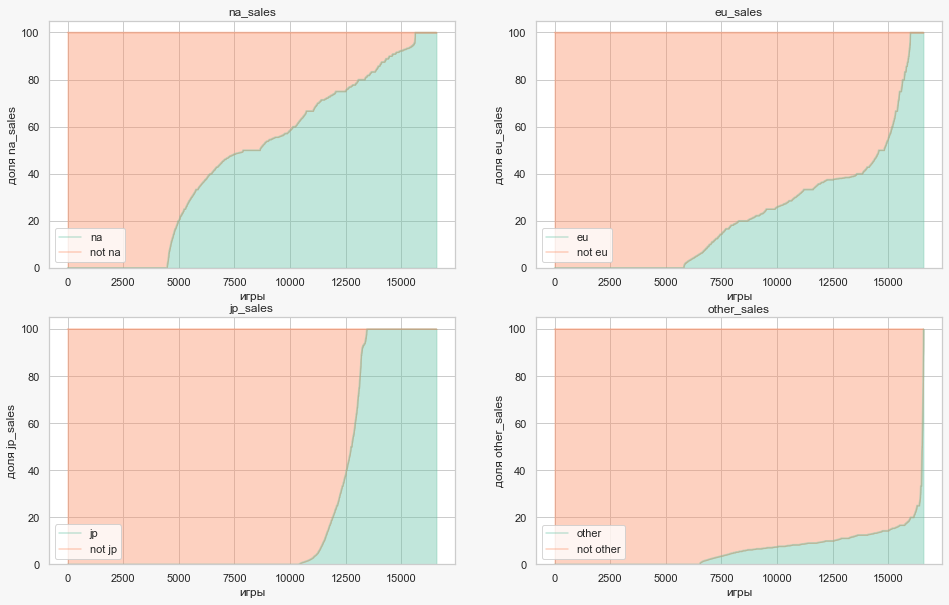

In [160]:
# строим графики

plt.close('all')
fig, axx = plt.subplots(2,2, figsize=(16,10))

i=0
for i in range(len(reg_lst)):
    x = reg_lst[i]
    r = i // 2 
    c = i % 2
    t['x_p'] = t[x] / t['total_sales']*100
    t['y_p'] = 100-t['x_p']

    t.hist(column='x_p', bins=30, ax=ax[r, c])
    t[['x_p','y_p']].sort_values('x_p').reset_index(drop=True)\
    .plot(kind='area', stacked=True, ax=axx[r, c], title='100 % stacked area chart',alpha=0.4)
    axx[r,c].legend([x[:-6], 'not '+ x[:-6]])
    axx[r,c].set_xlabel("игры")
    axx[r,c].set_ylabel("доля "+x)
    axx[r,c].set_title(x)
plt.show()

Как видим, JP - регион своих вкусов, пользователи игнорируют популярные игры других регионов и предпочитают свои игры, которые в других регионах не популярны. Доля игр исключительных для региона к числу игр, продаваемых в регионе около 60-65%<br>
NA - регион, который в среднем половину игр покупает. <br>
У NA и EU также есть свои специфичные игры, но доля исключительных игр около 9% от числа игр, продаваемых в регионе<br>
А регион Other вообще почти не имеет специфичных игр и играет в "чужие" игры, причем доля этого региона в доле продаж таких игр почти никогда не превышает 30%. Можно сказать несущественный и не специфичный регион.

Добавим столбец с признаком основного региона продаж. Основным назначим регион, если продажи игры в этом регионе более 90% от общих продаж worldwide.

In [161]:
df['main_reg'] = 'common'
df['main_reg'] = df['main_reg'].where(df['na_sales']<0.9*df['total_sales'], 'NA')
df['main_reg'] = df['main_reg'].where(df['eu_sales']<0.9*df['total_sales'], 'EU')
df['main_reg'] = df['main_reg'].where(df['jp_sales']<0.9*df['total_sales'], 'JP')
df['main_reg'] = df['main_reg'].where(df['other_sales']<0.9*df['total_sales'], 'OTHER')

### Сколько игр выпускалось в разные годы

Добавим функцию для удаления выбросов по методу 1,5 IQR

Она пригодится при анализе характерного времени жизни платформы и при тестировании гипотез

In [162]:
##  Функция для определения выбросов (по методу 1,5*IQR) и их удаления
### анализируется столбец param и для каждого уникального значения в этом столбце 
### смотрится распределение значений в столбце value и удаляются выбросы
def delete_outliers(df, param = 'column', value = 'user_score', k_lbound=1.5, k_ubound=1.5):
    lst = list(df[param].unique())

    for i in lst:
        t1 = df.query(param+' == @i')[value].describe()
        iqr = t1['75%']-t1['25%']
        l_bound = max(t1['25%'] - iqr*k_lbound, t1['min'])
        u_bound = min(t1['75%'] + iqr*k_ubound, t1['max'])
        print('\n'+param+' '+i)
        print(f'bounds 1.5*IQR are:({l_bound:.2f},{u_bound:.2f})')
        b = len(df)
        df = df.loc[(df[param] == i) & (df[value] <= u_bound) & (l_bound <= df[value]) | (df[param] != i)]
        print(f'Удалено:{(b-len(df))} ({(b-len(df))/b:.1%})')
    return df

In [163]:
# Сделаем функцию для построения графиков
def generate_plot(df, x = 'year', y='cnt', ci=None, hue=None
                  , title='График создания новых игр по годам' 
                  , xlabel='года'
                  , ylabel='число новых игр'
                  , figsize = (15,10)
                  , step=1
                  , rot=0
                 ):
    plt.figure(figsize = figsize)
    g = sns.lineplot(data = df, x=x, y=y, ci=ci, hue=hue)
    g.set_title(title)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    g.set_xticks(np.arange(start=min(df[x]), stop=max(df[x])+1,step=step))
    #g.set_xticklabels(g.get_xticklabels(),rotation = rot)
    plt.grid(visible=True, which='both', axis='both')
    plt.show;

Text(0, 0.5, 'число новых игр')

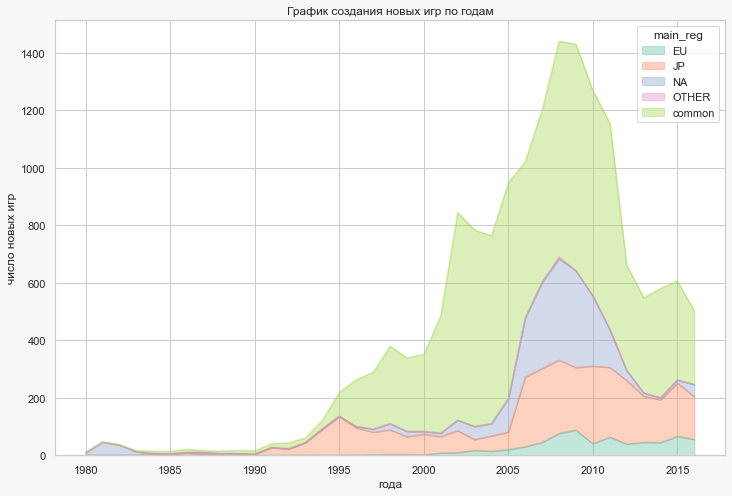

In [164]:
# временный фрейм
t = df.pivot_table(index='year_of_release', columns='main_reg', values='total_sales', aggfunc='count').fillna(0)

# график
g = t.plot.area(figsize = (12,8), alpha=0.4)
g.set_title('График создания новых игр по годам')
g.set_xlabel('года')
g.set_ylabel('число новых игр')

До 1990 отрасль была неразвитой и игры было мало. Потом произошел резкий рост. Образовали даже ассоциацию ESRB и стали назначать рейтинги, ставить оценки и т.д.

Для анализа левый хвост до 1994 года можно отсечь, там "темные века". А после определения цикла жизни игр можно еще сильнее будет сократить период для прогнозирования на 2017 год


C 2005 по 2012 было выпущено достаточно много игр (по 300 шт в год), нацеленных только на NA регион. В последние годы эксклюзивно для NA региона выпускается 10-30 игр в год.
с 2005 по н.в. EU регион выпускает ежегодно примерно по 50 игр только для своего региона.
JP регион стабильно выпускает уникальные игры только для своего региона (по 150-200 шт в год)


### Продажи платформ по годам

#### Общие продажи по годам

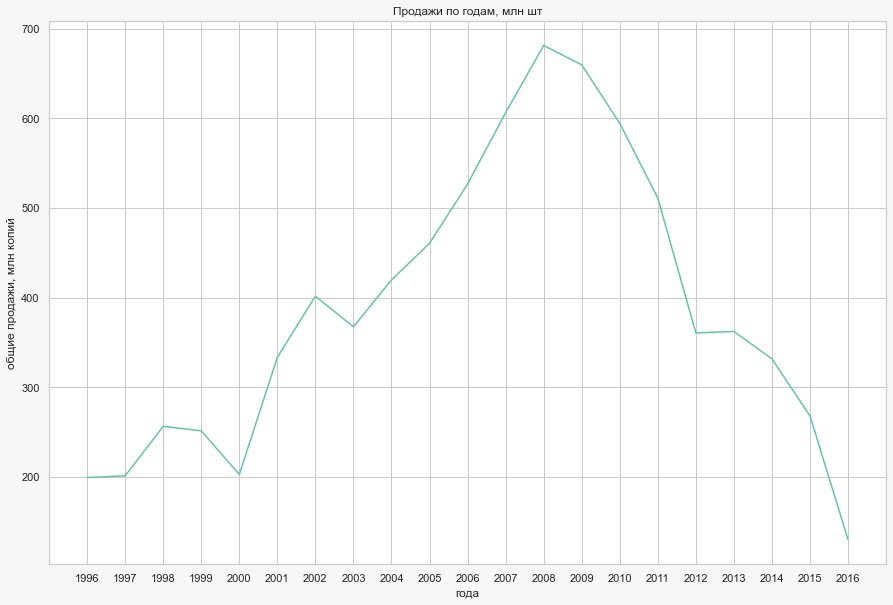

In [165]:
# подготовим данные во временном фрейме в сгруппированном виде
t = df.groupby(by=['year_of_release'])['total_sales'].sum().reset_index()
t.columns = ['year', 'total_sales']

# график
generate_plot(t.query('year > 1995'), y='total_sales', ylabel='общие продажи, млн копий', title='Продажи по годам, млн шт')

In [166]:
t.query('year > 2012')

,year,total_sales
33,2013,362.110
34,2014,331.530
35,2015,267.980
36,2016,129.940


2016 год просто рухнул вниз. Вероятно данные не за полный год

#### График в разрезе платформ

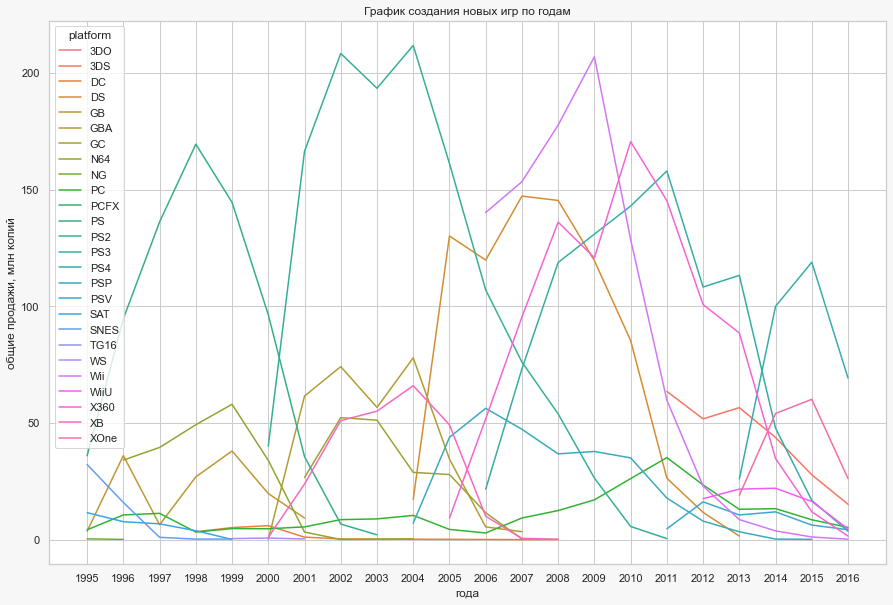

In [167]:
# подготовим данные во временном фрейме в сгруппированном виде
t = df.groupby(by=['platform', 'year_of_release'])['total_sales'].sum().reset_index()
t.columns = ['platform', 'year', 'total_sales']

# график
generate_plot(t.query('year > 1994'), y='total_sales', ylabel='общие продажи, млн копий', hue='platform')

Такой график трудно читать. Дальше будет лаконичный, только для крупных платформ

Но и тут видна чехарда, угасание одних платформ и рост новых

#### График популярных платформ по годам

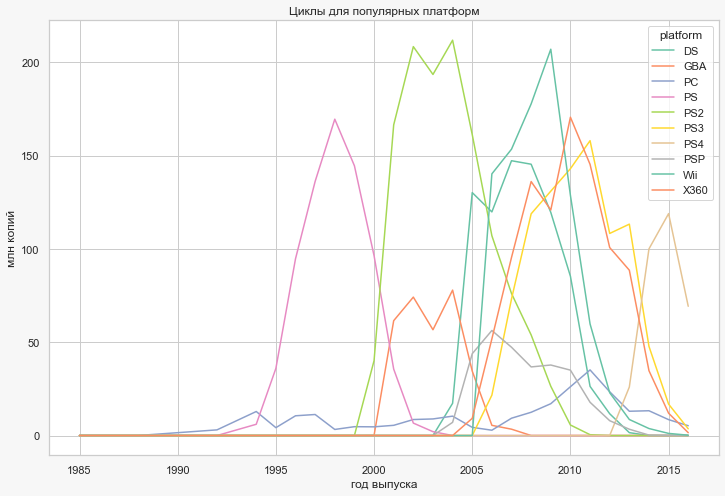

In [168]:
# список платформ ТОП10
lst_top10 = (
    df.groupby(by=['platform'])['total_sales'].sum()
    .sort_values(ascending=False)
    .head(10).index
)

# вспомогательная таблиа для построения графика
t = (
    df[df['platform'].isin(lst_top10)]
    .pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='sum')
    .fillna(0)
)

# строим график
t.transpose().plot(
    figsize=(12,8)
    , title="Циклы для популярных платформ")
plt.xlabel('год выпуска')
plt.ylabel('млн копий')
plt.show()

График не идеален, увидеть срок жизни сложновато. 

Для наглядности нужно привести все платформы в единую точку "год начала жизни платформы" = 1

И чтобы смотреть графики было удобно я нормализую продажи (разделю продажи платформы за год на общие продажи платформы за все года


Также удалим выбросы (небольшие продажи, в самом старте или в самом конце жизненных циклов платформ)

In [169]:
# фрейм для анализа срока жизни ТОП 10 платформ 
# удаляем аномальные выбросы (слишком долгое угасание платформ по 1-2 игры в год, например)

top_df = delete_outliers(
    df[df['platform'].isin(lst_top10)]
    , param = 'platform'
    , value = 'year_of_release'
    , k_lbound=1.5, k_ubound=1.5
)


platform Wii
bounds 1.5*IQR are:(2006.00,2013.00)
Удалено:11 (0.1%)

platform DS
bounds 1.5*IQR are:(2004.00,2012.00)
Удалено:9 (0.1%)

platform X360
bounds 1.5*IQR are:(2005.00,2015.50)
Удалено:13 (0.1%)

platform PS3
bounds 1.5*IQR are:(2006.00,2016.00)
Удалено:0 (0.0%)

platform PS2
bounds 1.5*IQR are:(2000.00,2011.00)
Удалено:0 (0.0%)

platform GBA
bounds 1.5*IQR are:(2000.00,2007.00)
Удалено:0 (0.0%)

platform PS4
bounds 1.5*IQR are:(2013.50,2016.00)
Удалено:16 (0.1%)

platform PS
bounds 1.5*IQR are:(1994.00,2002.00)
Удалено:3 (0.0%)

platform PC
bounds 1.5*IQR are:(1999.50,2016.00)
Удалено:40 (0.3%)

platform PSP
bounds 1.5*IQR are:(2004.00,2015.00)
Удалено:0 (0.0%)


In [170]:
# вспомогательный фрейм
ddf = (
        top_df[['platform', 'year_of_release', 'total_sales']]\
        .groupby(by=['platform', 'year_of_release'])['total_sales'].sum().reset_index()
        
)
#ddf = ddf.query('total_sales > 10')
# добавляем столбцы: сумму продаж платформы
ddf['sum_sales'] = ddf.groupby(['platform'])['total_sales'].transform('sum')
# доля продаж в год к общему числу продаж
ddf['pdf_sales'] = ddf['total_sales'] / ddf['sum_sales']


# добавляем столбцы с первым годом продаж игр на платформе
ddf['first_year_platform'] = ddf.groupby(['platform'])['year_of_release'].transform('min')

# с годом жизни платформы (для каждой платформы начинается с 1)
ddf['platform_life_year'] = ddf['year_of_release'] - ddf['first_year_platform'] +1

ddf.head()

,platform,year_of_release,total_sales,sum_sales,pdf_sales,first_year_platform,platform_life_year
0,DS,2004,17.270,802.720,0.022,2004,1
1,DS,2005,130.140,802.720,0.162,2004,2
2,DS,2006,119.810,802.720,0.149,2004,3
3,DS,2007,147.230,802.720,0.183,2004,4
4,DS,2008,145.360,802.720,0.181,2004,5


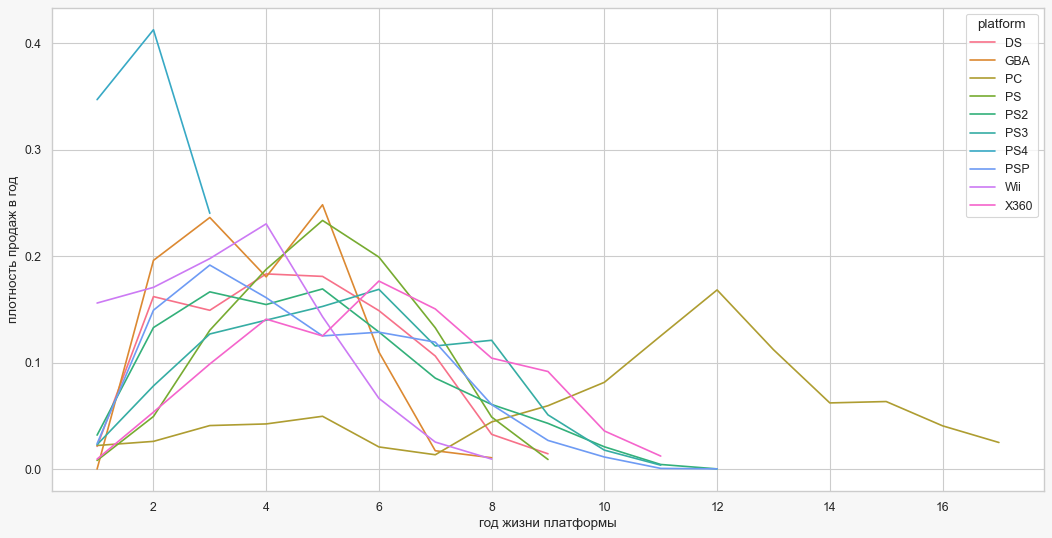

In [171]:
# строим график
plt.figure(figsize=(16, 8), dpi= 80)
sns.lineplot(data=ddf, x='platform_life_year', y='pdf_sales', hue='platform', ci=False)
#plt.gca().set(xlim=(-1, 15), ylim=(0, 0.4), xlabel='год жизни платформы', ylabel='плотность продаж в год');
plt.gca().set(xlabel='год жизни платформы', ylabel='плотность продаж в год');

Исключим PC как слишком особенную платформу с длинным сроком жизни, а также PS4 как только что созданную платформу

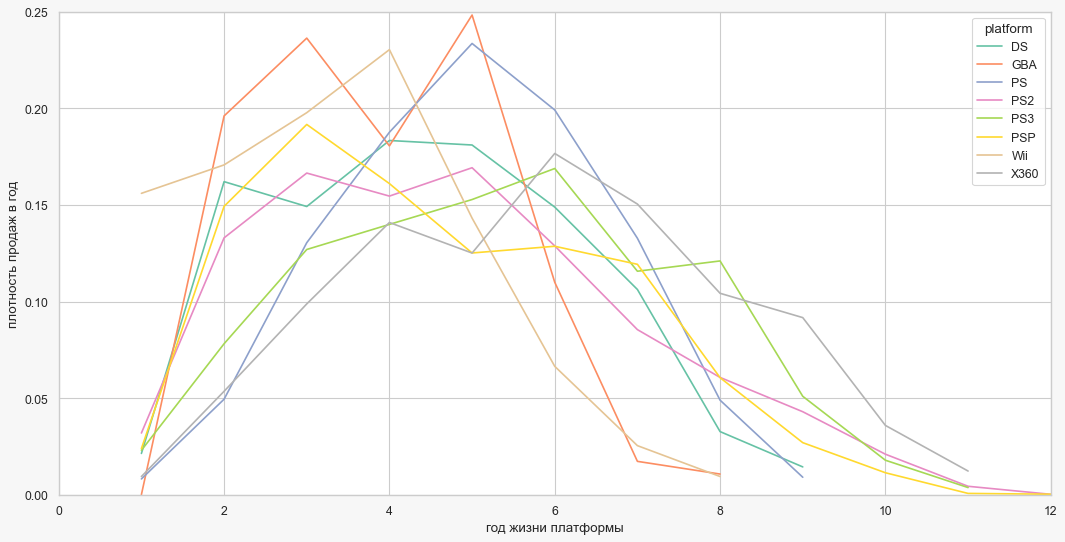

In [172]:
#Исключаем PC & PS4
ddf = ddf.query('platform != "PC" & platform != "PS4"').reset_index(drop=True)

# строим график
plt.figure(figsize=(16, 8), dpi= 80)
sns.lineplot(data=ddf, x='platform_life_year', y='pdf_sales', hue='platform', ci=False)
plt.gca().set(xlim=(0, 12), ylim=(0, 0.25), xlabel='год жизни платформы', ylabel='плотность продаж в год');

Вот теперь все хорошо видно! 

Первый год слабый, далее пик популярности и в конце срока видно угасание платформ. Распределение имеет положительную ассиметрию (правостороннее)

#### Определение времени жизни платформы

Из графика видим, что средний цикл жизни платформы около 8 лет. Попробуем посчитать поточнее

Считать будем тремя способами:
1. Посчитать стандартное отклонение года выпуска игры для каждой платформы. Если умножить на 3, то будет +/- 3\*sigma что подойдет для оценки
2. Посчитать разницу квантилей q(0.95) и q(0.05), это будет характерное время жизни без учета хвостиков становления и угасания
3. посчитать стандартные усы boxplot и разброс усов считать за время жизни платформы

In [173]:
def q95(arr):
    return arr.quantile(q=0.95, interpolation='linear')

def q05(arr):
    return arr.quantile(q=0.05, interpolation='linear')
def q25(arr):
    return arr.quantile(q=0.25, interpolation='linear')
def q75(arr):
    return arr.quantile(q=0.75, interpolation='linear')

t = (
    df
    .groupby(by=['platform'])
    .agg({'year_of_release': ['min', 'max', q05, q95, q25, q75, 'std'], 'total_sales':'sum'})
    .dropna()
    #.reset_index()
)
#t.columns = ['_'.join(col).strip() for col in t.columns.values]
t.columns = ['year_min', 'year_max', 'year_q05', 'year_q95', 'year_q25', 'year_q75', 'year_std', 'total_sales_sum']
t = t.sort_values(by='total_sales_sum', ascending=False)

t['year_q95-q05'] = t['year_q95'] - t['year_q05']
t['year_3std'] = t['year_std'] * 3

# считаем IQR и усы
t['year_iqr'] = t['year_q75']-t['year_q25']
t['year_u'] = t['year_q75'] + t['year_iqr'] * 1.5
t['year_l'] = t['year_q25'] - t['year_iqr'] * 1.5
t['year_whiskers'] = t[['year_u','year_max']].min(axis=1) - t[['year_l','year_min']].max(axis=1)
t

,year_min,year_max,year_q05,year_q95,year_q25,year_q75,year_std,total_sales_sum,year_q95-q05,year_3std,year_iqr,year_u,year_l,year_whiskers
platform,,,,,,,,,,,,,,
PS2,2000,2011,"2,001.000","2,009.000","2,002.000","2,007.000",2.565,"1,250.920",8.000,7.694,5.000,"2,014.500","1,994.500",11.000
X360,2005,2016,"2,006.000","2,014.000","2,008.000","2,011.000",2.458,966.670,8.000,7.373,3.000,"2,015.500","2,003.500",10.500
PS3,2006,2016,"2,007.000","2,015.000","2,009.000","2,013.000",2.457,935.180,8.000,7.370,4.000,"2,019.000","2,003.000",10.000
Wii,2006,2016,"2,007.000","2,011.000","2,008.000","2,010.000",1.550,903.310,4.000,4.651,2.000,"2,013.000","2,005.000",7.000
DS,1985,2013,"2,005.000","2,011.000","2,007.000","2,009.000",1.780,804.280,6.000,5.340,2.000,"2,012.000","2,004.000",8.000
PS,1994,2003,"1,995.000","2,001.000","1,997.000","1,999.000",1.848,727.580,6.000,5.544,2.000,"2,002.000","1,994.000",8.000
PS4,2013,2016,"2,014.000","2,016.000","2,015.000","2,016.000",0.868,314.140,2.000,2.605,1.000,"2,017.500","2,013.500",2.500
GBA,2000,2007,"2,001.000","2,006.000","2,002.000","2,004.000",1.477,313.730,5.000,4.432,2.000,"2,007.000","1,999.000",7.000
PSP,2004,2015,"2,005.000","2,013.000","2,006.500","2,011.000",2.432,293.570,8.000,7.297,4.500,"2,017.750","1,999.750",11.000


По графику мы примерно видели, что время жизни около 8 лет, по таблице тоже видим это. Уберем платформы, которые стартовали недавно, после 2013, чтобы такие свежие платформы не повлияли на оценку времени жизни

In [174]:
t = t.query('year_min <= 2013')

Построим график времени жизни разными способами. Нужно выбрать каким способом считать, насколько они совпадают, коррелируют

Считать будет по усеченной выборке ТОП20, отсекая мелкие платформы

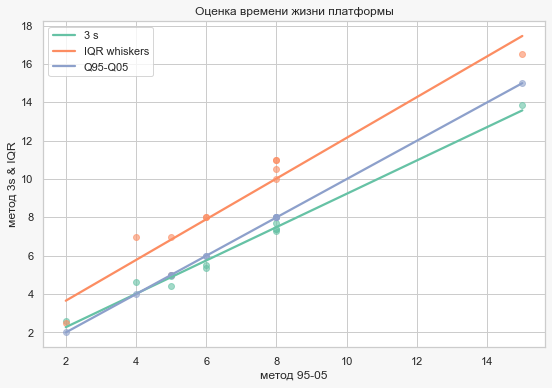

In [175]:

t = t.head(11)

g= sns.regplot( x='year_q95-q05', y='year_3std', data=t
               , ci=0
               , scatter_kws = {"alpha": 0.6}
);
sns.regplot( x='year_q95-q05', y='year_whiskers', data=t
                , ax=g
                , ci=0
                , scatter_kws = {"alpha": 0.6}
);
sns.regplot( x='year_q95-q05', y='year_q95-q05', data=t
                , scatter_kws = {"alpha": 0.6}
                , ax=g
                , ci=0
);
g.legend(['3 s', 'IQR whiskers', 'Q95-Q05'])
g.set_xlabel('метод 95-05')
g.set_title('Оценка времени жизни платформы')
g.set_ylabel('метод 3s & IQR')
plt.show()

In [176]:
t[['year_q95-q05', 'year_3std', 'year_whiskers']].corr()

,year_q95-q05,year_3std,year_whiskers
year_q95-q05,1.000,0.993,0.965
year_3std,0.993,1.000,0.957
year_whiskers,0.965,0.957,1.000


Все методы сильно коррелируют друг с другом. Все хороши, но мне больше всего симпатичен q95-q05

In [177]:
t[['year_q95-q05', 'year_3std', 'year_whiskers']].agg(['mean', 'median'])

,year_q95-q05,year_3std,year_whiskers
mean,6.818,6.466,8.773
median,6.000,5.544,8.000


**ВЫВОД**

В итоге время жизни оценим по q95-q05, характерное время жизни 6.5 лет

#### Коректный аналитический метод

Мы допустили неприятное упрощение. Изначально мы строили график продаж числа копий игр (млн.шт), расмотрели график и по графику продаж млн копий игры от года выпуска игры оценили время жизни игры.

А потом совершили подмену, ошибку. Мы далее считали квантили для числа релизов игр. Не млн копий, а просто числа новых разных игр (шт).

Если каждая игра стоит 1 доллар, то сначала мы смотрели распределения долларов по годам, а потом анализировали распределение числа релизов по годам. Разные вещи! На практике этого кейса за счет большого числа релизов и ЦПТ это близкие штуки, но в общем случае такие подмены понятий вещь мягко говоря не корректная.

Постараемся исправить эту ошибку. 
К сожалению стандартные функции std и quantile тут не помогут, придется "искать выход"

Построим cdf млн копий по годам для каждой платформы, определим по cdf квантили

In [178]:
# фрейм для анализа. ТОП платформы + группировка по годам
top_df = (
    df[df['platform'].isin(lst_top10)][['platform', 'year_of_release', 'total_sales']]\
    .groupby(by=['platform', 'year_of_release'])['total_sales']
    .sum().reset_index()
    .sort_values(by=['platform', 'year_of_release'])
)


# добавляем накопительный итог по годам. Фрейм ранее отсортирован
top_df['sales_cs'] = top_df.groupby(by=['platform'])['total_sales'].cumsum()

# добавляем столбцы: сумму продаж платформы
top_df['sum_sales'] = top_df.groupby(['platform'])['total_sales'].transform('sum')
# доля продаж в год к общему числу продаж
top_df['pdf_sales'] = top_df['total_sales'] / top_df['sum_sales']

# доля продаж в год к общему числу продаж
top_df['cdf_sales'] = top_df['sales_cs'] / top_df['sum_sales']

# получили cdf для каждой платформы
top_df.head(15)

,platform,year_of_release,total_sales,sales_cs,sum_sales,pdf_sales,cdf_sales
0,DS,1985,0.020,0.020,804.280,0.000,0.000
1,DS,2004,17.270,17.290,804.280,0.021,0.021
2,DS,2005,130.140,147.430,804.280,0.162,0.183
3,DS,2006,119.810,267.240,804.280,0.149,0.332
4,DS,2007,147.230,414.470,804.280,0.183,0.515
5,DS,2008,145.360,559.830,804.280,0.181,0.696
6,DS,2009,119.560,679.390,804.280,0.149,0.845
7,DS,2010,85.350,764.740,804.280,0.106,0.951
8,DS,2011,26.330,791.070,804.280,0.033,0.984
9,DS,2012,11.670,802.740,804.280,0.015,0.998


In [179]:
#lst_top10 содержит ТОП 10 платформ

# точки для cdf
points = [0.001, 0.005, 0.01, 0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975, 0.99, 0.995, 0.999]

# делаем пустой фрейм
res_df = pd.DataFrame(columns=['platform', 'min', 'q005', 'q01', 'q025', 'q05', 'q25', 'q50', 'q75', 'q95', 'q975', 'q99', 'q995', 'max'])

#цикл заполняет фрейм статистиками 
for i in range(len(lst_top10)):
    platf_name = lst_top10[i]
    
    # определяем интерполяционную функцию для вычисления cdf в заданных точках
    ##  функция f определяет год, в котором была достигнута заданная точка cdf
    ##  далее будет рассчитан момент в году когда это была достигнута заданная точка cdf
    ##  kind='linear' при интерполяции не подходит, т.к. некорректно работает при наличии 
    ### пропусков (нулевые продажи в годах), например platform = DS
    f = itpl.interp1d(
        top_df.query('platform == @platf_name')['cdf_sales'], 
        top_df.query('platform == @platf_name')['year_of_release'], 
        kind='next',  
        axis=- 1, 
        copy=True, 
        bounds_error=None, 
        fill_value='extrapolate', 
        assume_sorted=True)
    
    # массив, в который собираем данные и его потом добавим в фрейм res_df
    rw = [platf_name]
    
    # цикл по точкам для определния cdf
    for j in range(len(points)):
        q = points[j]
        
        # год в котором случилось достижение "точки" q
        y = int(f(q))
        
        row = top_df.query('(platform == @platf_name) & (year_of_release == @y)').head(1)
        
        # cdf_u - значение cdf в цонце года y
        # cdf_l - значение cdf в начале года y
        cdf_u = float(row['cdf_sales'])
        cdf_l = cdf_u - float(row['pdf_sales'])
        
        # вычисление дробной даты (float) cdf(res) == points[j]
        # 2017.0001 - начало года 2017, а 2017.9999 - конец 2017 года
        res = y + (q-cdf_l)/(cdf_u-cdf_l)
        
        rw += [res]
    # записываем в фрейм res_df массив (станет строкой фрейма)
    res_df.loc[i] = rw
res_df

,platform,min,q005,q01,q025,q05,q25,q50,q75,q95,q975,q99,q995,max
0,PS2,"2,000.031","2,000.156","2,000.312","2,000.779","2,001.135","2,002.510","2,004.081","2,005.732","2,008.442","2,009.046","2,009.757","2,009.994","2,010.858"
1,X360,"2,005.105","2,005.524","2,006.009","2,006.289","2,006.755","2,008.626","2,010.411","2,011.971","2,013.999","2,014.692","2,015.319","2,015.723","2,016.364"
2,PS3,"2,006.043","2,006.216","2,006.432","2,007.024","2,007.343","2,009.154","2,010.861","2,012.516","2,014.449","2,014.938","2,015.658","2,015.936","2,016.740"
3,Wii,"2,006.006","2,006.032","2,006.064","2,006.161","2,006.322","2,007.558","2,008.890","2,009.996","2,011.857","2,012.611","2,013.539","2,014.148","2,015.366"
4,DS,"2,004.045","2,004.232","2,004.465","2,005.022","2,005.176","2,006.448","2,007.916","2,009.363","2,010.992","2,011.738","2,012.443","2,012.787","2,013.478"
5,PS,"1,994.121","1,994.603","1,995.035","1,995.338","1,995.844","1,997.332","1,998.536","1,999.715","2,001.223","2,001.734","2,002.220","2,002.765","2,003.649"
6,PS4,"2,013.012","2,013.060","2,013.121","2,013.302","2,013.604","2,014.525","2,015.261","2,015.922","2,016.773","2,016.887","2,016.955","2,016.977","2,016.995"
7,GBA,"2,001.004","2,001.024","2,001.050","2,001.126","2,001.254","2,002.227","2,003.372","2,004.550","2,005.802","2,006.186","2,007.077","2,007.539","2,007.908"
8,PSP,"2,004.042","2,004.208","2,004.416","2,005.006","2,005.174","2,006.400","2,007.837","2,009.766","2,011.832","2,012.547","2,013.238","2,013.672","2,014.277"
9,PC,"1,992.062","1,992.404","1,992.831","1,994.262","1,994.765","2,002.530","2,009.730","2,011.966","2,015.097","2,015.857","2,016.507","2,016.753","2,016.951"


In [180]:
# вычисляем время жизни платформы разными способами
res_df['life_q99-q01'] = res_df['q99']-res_df['q01']

res_df['life_q95-q05'] = res_df['q95']-res_df['q05']

res_df['uwb'] = res_df['q75'] + 1.5*(res_df['q75']-res_df['q25'])
res_df['lwb'] = res_df['q25']  - 1.5*(res_df['q75']-res_df['q25'])
res_df['life_iqr'] = res_df[['max', 'uwb']].min(axis=1) - res_df[['min', 'lwb']].max(axis=1)

res_df['life_q995-q005'] = res_df['q995']-res_df['q005']

res_df['life_max-min'] = res_df['max']-res_df['min']



# считаем средние времена жизни платформ, вычисленные разными способами
res_df.query('platform != "PC" & platform != "PS4"')[['life_iqr', 'life_q95-q05', 'life_q99-q01', 'life_q995-q005', 'life_max-min']].mean()

life_iqr         9.485
life_q95-q05     6.199
life_q99-q01     8.183
life_q995-q005   8.821
life_max-min     9.780
dtype: float64

**ВЫВОД**

В итоге время жизни оценим так: 
* средняя платформа выпускает 90% копий своих игр за 6 лет (активная часть жизни платформы) 
* средняя платформа выпускает 98% копий своих игр за 8 лет (это я бы и назвал средним сроком жизни) 
* среднее время полного цикла жизни платформы около 10 лет с учетом времени угасания

**Примечание:** Этот срок жизни платформы не включает время активного использования самих игр. В теории можно 3 года выпускать игры и потом еще 10 лет продавать приставки для этих игр. И наша оценка срока жизни платформы по дате выпуска игры будет 3 года, а правильной была бы 13 лет. На практике наверное средний срок пользования игрой около года, т.е. к нашей оценке можно добавить еще 1 год.

### АКТУАЛЬНЫЙ ПЕРИОД

Для прогноза на 2017 достаточно данных за 3-4 года. 
Данные за 2016 год вероятно неполные, на них полагаться при прогнозировании нельзя.
Ограничим даные диапазоном [2012-2015]

In [181]:
# Делаем новый фрейм только за актуальный период
act_df = df.query('2013 <= year_of_release <= 2016')

# Вспомогательная таблица по годам и платформам
t = (
    act_df
    .pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
    .fillna(0)
    .sort_values(by=[2015], ascending=False)
)
t

year_of_release,2013,2014,2015,2016
platform,,,,
PS4,25.990,100.000,118.900,69.250
XOne,18.960,54.070,60.140,26.150
3DS,56.570,43.760,27.780,15.140
PS3,113.250,47.760,16.820,3.600
WiiU,21.650,22.030,16.350,4.600
X360,88.580,34.740,11.960,1.520
PC,13.010,13.280,8.520,5.250
PSV,10.590,11.900,6.250,4.250
Wii,8.590,3.750,1.140,0.180


Лидерами рынка в последние пару лет являются: PS4, XOne, 3DS, PS3, WiiU, X360

Продажи игр на PS4, XOne в 2015 к 2014 выросли, продажи 3DS, PS3, WiiU, X360 в 2015 к 2014 продолжили сокращаться

#### график «ящик с усами» по глобальным продажам игр

<a name="bxpltws"></a>

In [182]:
t.index

Index(['PS4', 'XOne', '3DS', 'PS3', 'WiiU', 'X360', 'PC', 'PSV', 'Wii', 'PSP',
       'DS'],
      dtype='object', name='platform')

describe                                                    sum
            count  mean   std   min   25%   50%   75%    max total_sales
platform                                                                
3DS       303.000 0.473 1.381 0.010 0.040 0.090 0.280 14.600     143.250
DS          8.000 0.193 0.172 0.030 0.068 0.150 0.253  0.510       1.540
PC        192.000 0.209 0.350 0.010 0.030 0.080 0.230  3.050      40.060
PS3       345.000 0.526 1.452 0.010 0.040 0.150 0.510 21.050     181.430
PS4       392.000 0.801 1.609 0.010 0.060 0.200 0.730 14.630     314.140
PSP        68.000 0.055 0.064 0.010 0.018 0.020 0.080  0.240       3.740
PSV       358.000 0.092 0.154 0.010 0.020 0.040 0.110  1.960      32.990
Wii        23.000 0.594 0.915 0.010 0.045 0.180 0.755  3.580      13.660
WiiU      115.000 0.562 1.039 0.010 0.060 0.200 0.595  7.090      64.630
X360      186.000 0.735 1.663 0.010 0.080 0.265 0.795 16.270     136.800
XOne      247.000 0.645 1.036 0.010 0.060 0.220 0.685  7.390     159.320

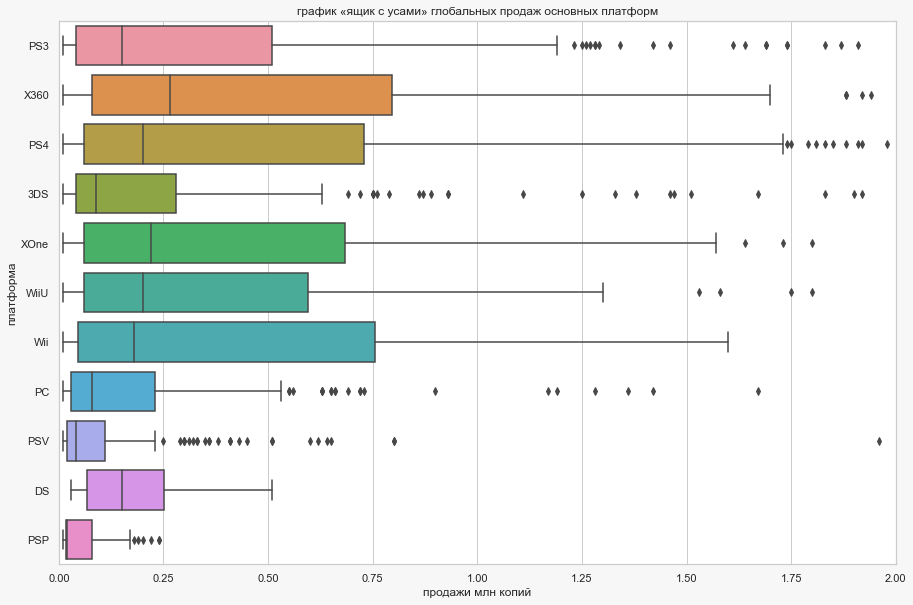

In [183]:
t1 = act_df[act_df['platform'].isin(t.index)]
plt.figure(figsize=(15, 10))
sns.boxplot(data=t1, y='platform', x='total_sales')
plt.gca().set(xlim=(0, 2), xlabel='продажи млн копий', ylabel='платформа', title="график «ящик с усами» глобальных продаж основных платформ");
plt.show
t1.groupby('platform')['total_sales'].agg(['describe', 'sum'])

1. Безусловным лидером является PS4, 
2. далее идет XOne, которые в сумме за 3 года продают игр меньше PS3 или 3DS, зато почти в 2 раза каждая игра в среднем больше продается, да и уже в 2014 и 2015 они обогнали PS3 и 3DS.
3. Далее 3DS, который сопоставим с PS3 по общим продажам, но имеет преимущество в виде пары супер-популярных игр. С другой стороны, у 3DS самый низкий IQR и Q3, что говорит о высокой доле неудач с играми
4. X360 примечательна тем, что после PS4, XOne имеет самую высокую медиану, что говорит о высоком шансе запустить успешные игры, пусть и не супер-бестселлер, но успешные.


Основной акцент стоит делать на популярных платформах PS4, XOne 

### Влияние на продажи отзывов пользователей и критиков.

In [184]:
# определим UDF для построения матрицы корреляций и создания временного датафрейма
def explr_platform(df, plt='PS4'):
    # сделаем анализ игр PS4. Сделаем временный фрейм
    t = df.query('platform == "'+plt+'"')[['total_sales','critic_score', 'user_score']]

    # строим матрицу корреляций
    t1 = t.corr(method='spearman')

    # выводим heatmap
    #sns.set(rc = {'figure.figsize':(6,6)})
    g = sns.heatmap(t1,  vmin=-1, vmax=1, cmap='coolwarm', linewidths=.5, annot=True)
    g.set_title('Корреляции '+plt)

    
    pd.plotting.scatter_matrix(t, figsize=(15, 15), grid=True, hist_kwds={'bins':30})

    return


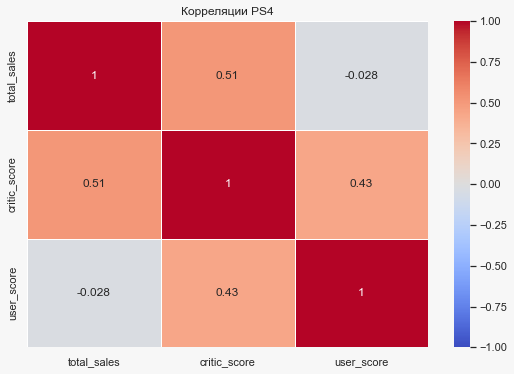

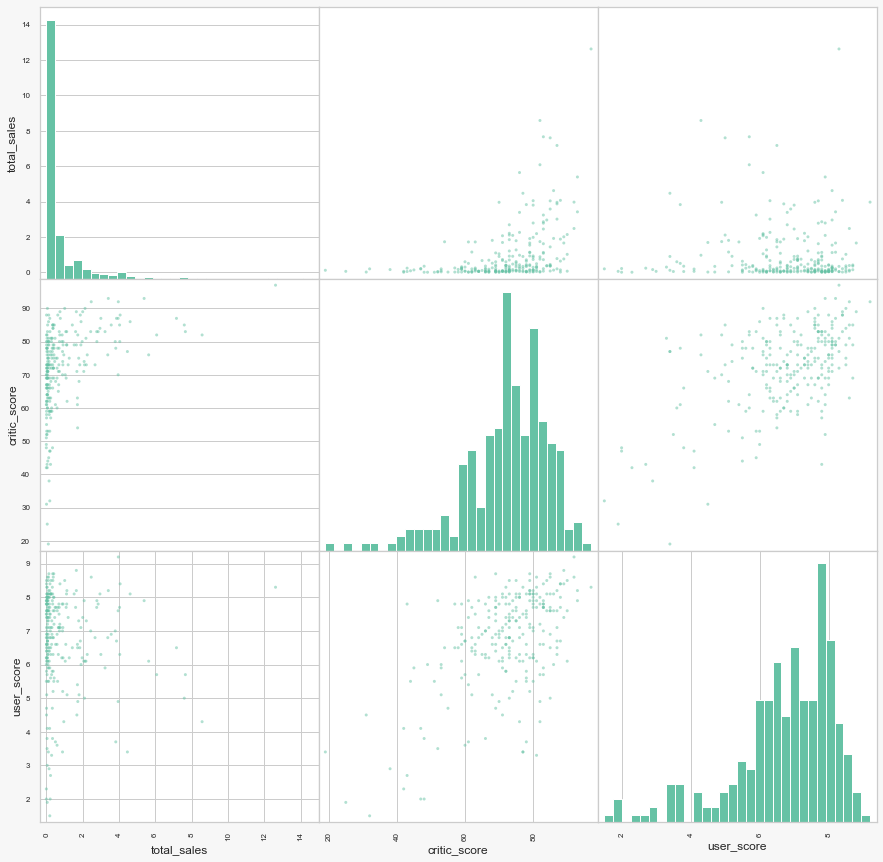

In [185]:
explr_platform(act_df, 'PS4')

Интересное дело: оценки критиков все же лучше корреклируют с продажами чем оценки пользователей. Пользователи ведут себя странно: оценивают средне но покупают, а когда оценивают высоко - покупают мало.

Оценки критиков и пользователей в целом коррелируют, связь есть.

смотрим на другие платформы:

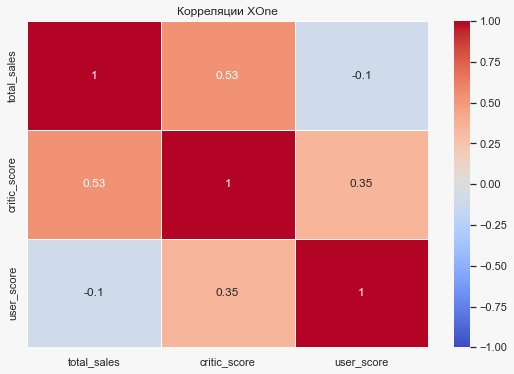

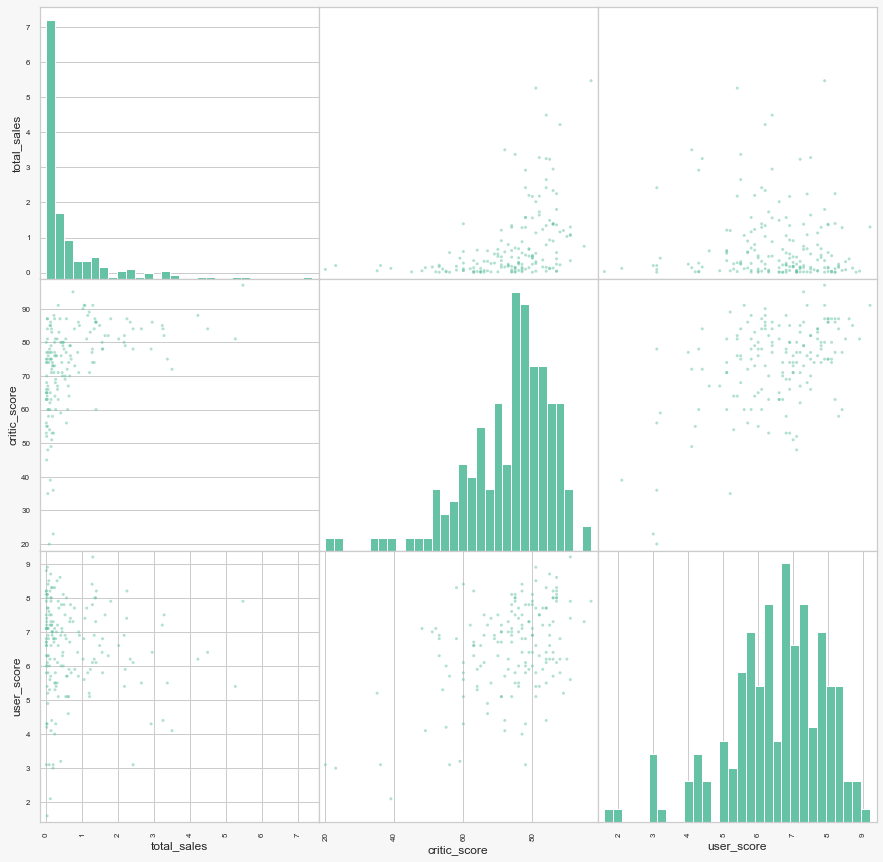

In [186]:
 t = explr_platform(act_df, 'XOne')

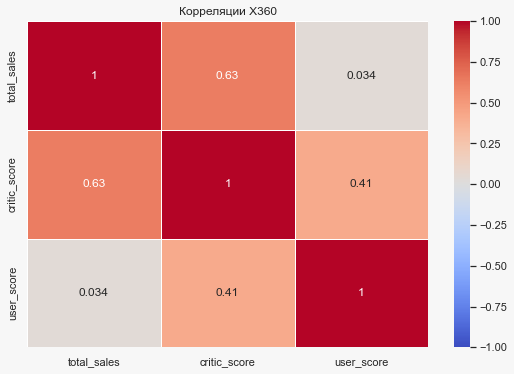

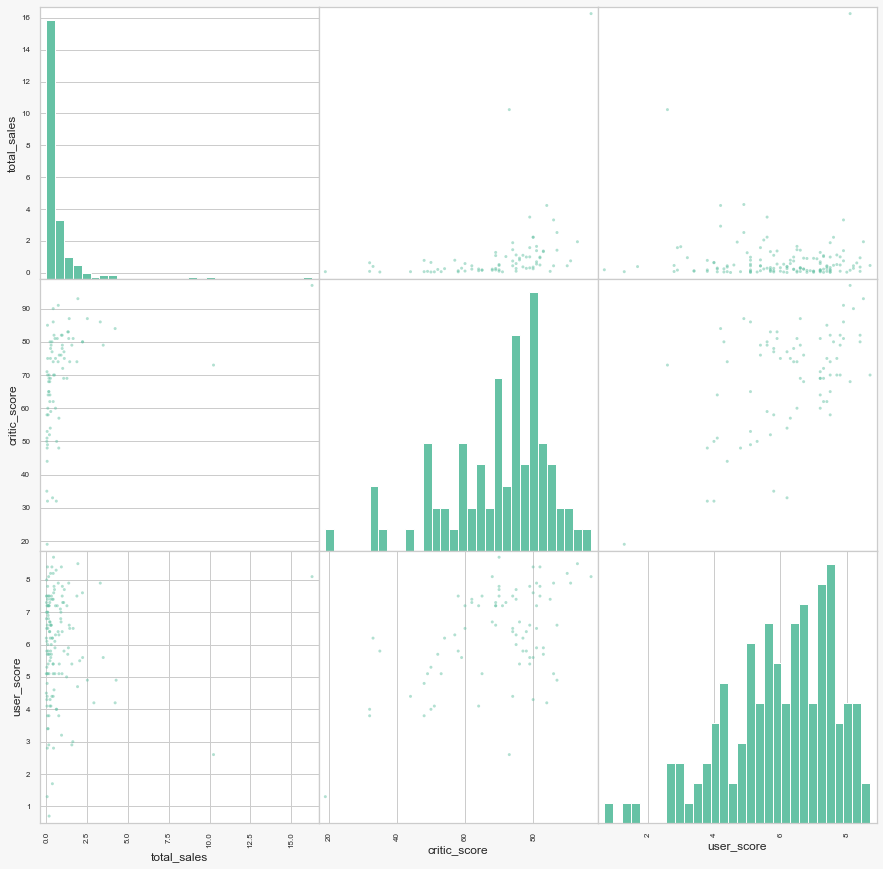

In [187]:
 t = explr_platform(act_df, 'X360')

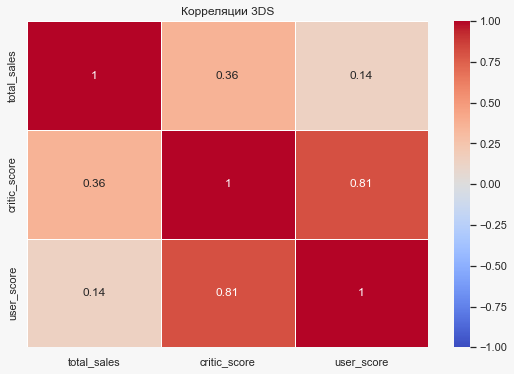

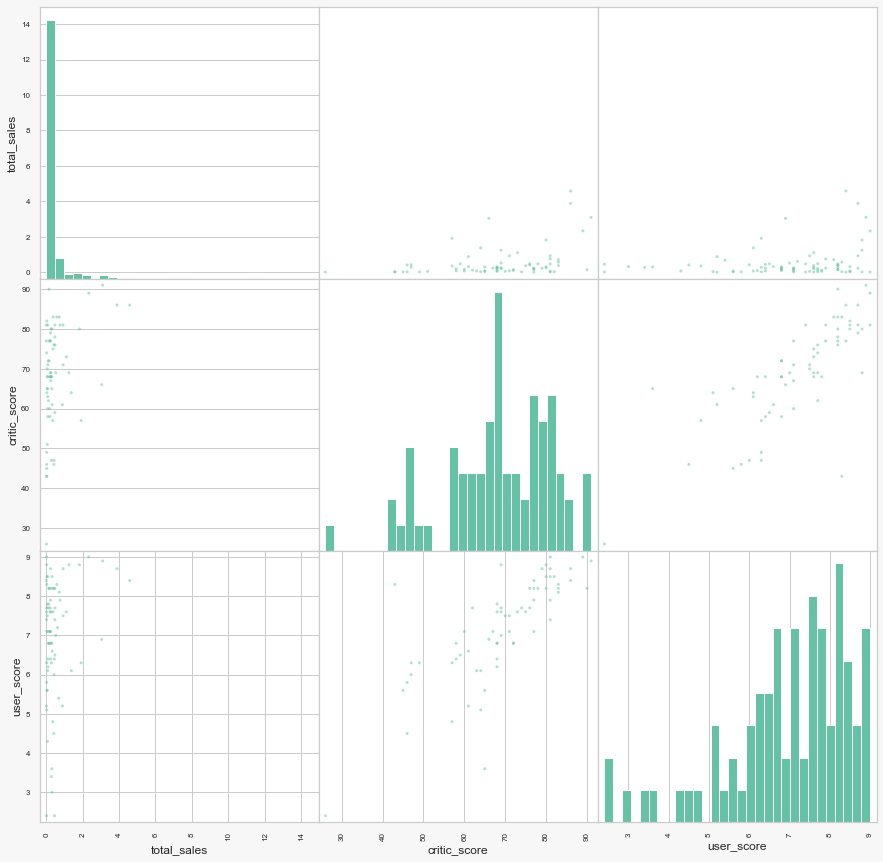

In [188]:
t = explr_platform(act_df, '3DS')

В целом, на других платформах  та же самая ситуация, критики лучше оценивают игры чем сами пользователи<br>
Влияние оценок критиков на продажи умеренное, причем для высоких оценок (выше 60-70) влияние сильнее, а низкие оценки почти не влияют на продажи.

Выделить стоит платформу 3DS, чьи продажи самую малость лучше коррелируют с оценками пользователей

### общее распределение игр по жанрам

<a name="tpg"></a>

In [189]:
act_df.groupby(by='genre')['total_sales'].agg(['median']).sort_values(by='median', ascending=False)

,median
genre,
Shooter,0.445
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Misc,0.105
Simulation,0.100


жанры лидеры: Shooter, Sports, Platform, Role-Playing

анти-лидеры: Puzzle, Adventure

## Шаг 4. Портрет пользователя региона

Определим функцию для таблицы анализа регионов по параметру

In [190]:
# UDF
def reg_evaluate_old(act_df, param='platform'):
    lst = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
    t = pd.DataFrame(index=range(5))
    for col in lst:
        t1 = act_df.groupby(by=param)[col].agg(['sum']).sort_values(by='sum', ascending=False).reset_index()
        t1['frac'] = t1['sum']/t1['sum'].sum()
        t1 = t1.head(5)
        t1 = t1[[param, 'frac']]
        t1.columns = [col+'_'+param, col+'_frac']
        t = t.join(t1)

    t.columns = [np.array(['NA','NA','EU','EU','JP','JP','other','other']), 
                 np.array([param,'frac',param,'frac',param,'frac',param,'frac'])]
    display(t)
    return


In [219]:
# UDF
# для каждого региона выбираем топ 5 объектов param с наибольшими продажами
# Все остальные (после топ5) обозначим Other
# + строим 4 pie plot

def reg_evaluate(act_df, param='platform'):
    lst = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,8), gridspec_kw={'hspace':1.25})
    t = pd.DataFrame(index=range(6))
    for i in range(len(lst)):
        
        # Готовим для lst[i] табличку с долями param (ТОП5 + other)
        col = lst[i]
        t1 = act_df.groupby(by=param)[col].agg(['sum']).sort_values(by='sum', ascending=False).reset_index()
        t1['frac'] = t1['sum']/t1['sum'].sum()
        top5 = t1.head(5)[param]
        t1['grp'] = t1[param].where(t1[param].isin(top5), 'Other')
        t1['grp_i'] = 1
        t1.loc[t1['grp']=='Other','grp_i'] = 0
        t2 = t1.pivot_table(index=['grp_i', 'grp'], values='frac', aggfunc='sum').reset_index().sort_values(by=['grp_i', 'frac'], ascending=False)
        
        # добавляем pie plot
        t2.set_index('grp').plot(kind='pie', y='frac', ax=ax[i], normalize=True)
        ax[i].legend(loc='center', ncol=2, bbox_to_anchor=(0.5, -0.2))
        ax[i].set_ylabel("")
        ax[i].set_title(col.replace("_sales", "").upper() + ' region', fontdict={'fontsize':14})

        # приклеиваем t2  в общую таблицу
        t2 = t2[['grp', 'frac']].reset_index(drop=True)
        t2.columns = [col+'_'+param, col+'_frac']
        t = t.join(t2)

    t.columns = [np.array(['NA','NA','EU','EU','JP','JP','other','other']), 
                     np.array([param,'frac',param,'frac',param,'frac',param,'frac'])]
    t = t.dropna(axis=0, how='all')
    display(t.style.hide_index().set_caption(param))
    print()


    plt.show()



### Самые популярные платформы

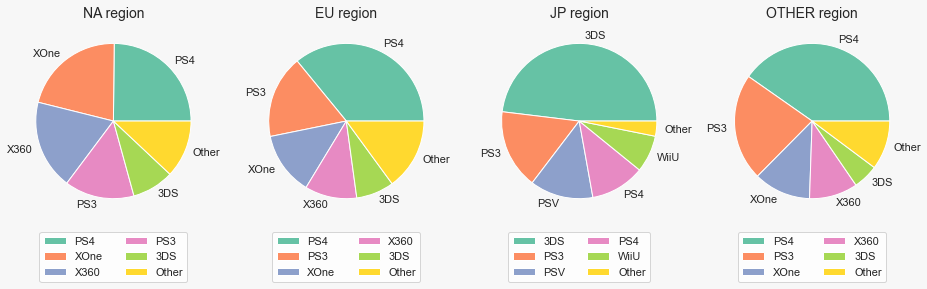

In [220]:
reg_evaluate(act_df, 'platform')

**вывод**<br>
- NA и EU похожи по предпочтениям. Основные платформы это: PS4 (25-36%), XOne(13-21%), X360 (11-19%), PS3 (15-17%), 
- JP отличается существенно по предпочтениям. Основные платформы это: 3DS (49%), PSV (13%), PS3 (17%), PS4 (11%), WiiU(8%)
- Из общего: PS3 всех регионов имеет долю 10-14%.

### Самые популярные жанры

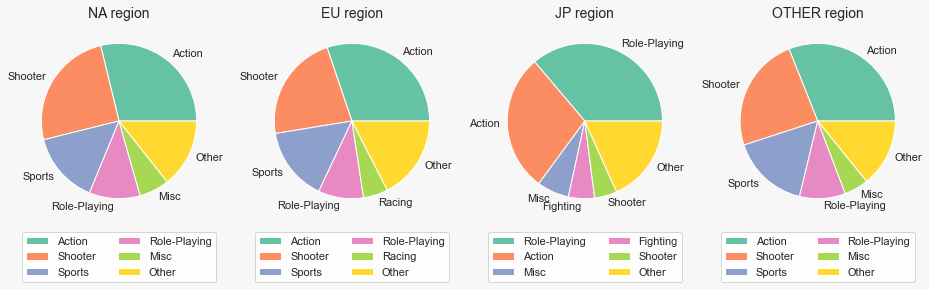

In [221]:
reg_evaluate(act_df, 'genre')

**вывод**<br>
- NA и EU похожи по предпочтениям. Основные жанры это: Action (26-29%), Shooter(22-26%), Sports(15-16%), Role-Playing (10-11%), Racing (5-6%)
- JP отличается существенно по предпочтениям. Основные жанры это: Role-Playing (33%), Action (30%), Fighting (8%), Misc (6%), Shooter(5%)
- Из общего: Action всех регионов имеет долю от 26-30%.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе

NA           EU           JP        other      
  rating  frac rating  frac rating  frac rating  frac
0      M 0.400      M 0.400     RP 0.573      M 0.423
1      E 0.187      E 0.218      T 0.162      E 0.193
2     RP 0.166     RP 0.156      E 0.113     RP 0.150
3   E10+ 0.129   E10+ 0.115      M 0.107      T 0.125
4      T 0.119      T 0.111   E10+ 0.044   E10+ 0.110

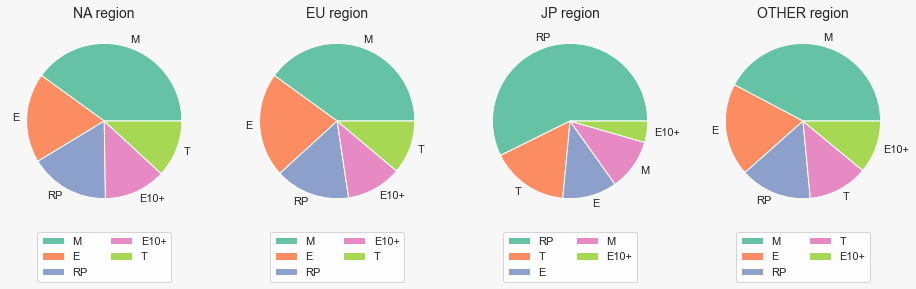

In [194]:
reg_evaluate(act_df, 'rating')

Такой анализ показывает игры с каким рейтингом предпочитают в каком регионе и позволит составить портрет игрока
- для NA/EU предпочтительный M(взрослый) рейтинг и точно не T
- для JP в основном продаются игры без рейтинга (RP), а M в хвосте

Наверное такой анализ и задумывался, но мне кажется так неправильно смотреть **влияние рейтинга на продажи**<br>

**Правильное решение** на мой взгляд такое:<br>
Нужно смотреть на средние продажи игры для определенной платформы и определенного жанра данного рейтинга по отношению к средним продажам для этой платформы и этого жанра уже всех рейтингов.<br>
Такой коэффициент показывал бы как **влияет** рейтинг на продажи игры при прочих равных<br>

Делаем две вспомогательные функции и смотрим регионы

In [195]:
##   Функция готовит таблицу где для каждой платформы, жанра 
###  рассчитывается коэффициент влияния рейтинга на среднюю продаваемость
def prep_tbl(df, param = 'total_sales'):
    t=df.groupby(by=['platform', 'genre','rating'])[param].agg(['mean', 'count', 'sum']).reset_index()
    t['s1'] = t.groupby(by=['platform', 'genre'])['sum'].transform('sum')
    t['c1'] = t.groupby(by=['platform', 'genre'])['count'].transform('sum')
    t['mean_all_ratings'] = t['s1']/t['c1']
    t['effect'] = t['mean'] / t['mean_all_ratings']
    return t

##  Функция использует подготовленную таблицу коэффициент влияния рейтинга на среднюю продаваемость
### строит гистограммы и описательную табличку
def show_hist_ratings(t, region):
    lst = list(t['rating'].unique())
    i=0
    for r in lst:
        if i==0:
            q = t.query('rating == @r').plot(kind='hist', y='effect', 
                                        histtype='step',
                                        density=True,
                                        bins=10,
                                        alpha=0.7,
                                        linewidth=2,
                                        label=r,
                                        figsize=(10,7),
                                        xlim=(0,5),
                                        title = "Гистограмма " + region
                )
        else:
            t.query('rating == @r').plot(kind='hist', y='effect', 
                                        histtype='step',
                                        density=True,
                                        bins=10,
                                        alpha=0.7,
                                        linewidth=2,
                                        label=r,
                                        figsize=(10,7),
                                        ax=q,
                                        title = "Гистограмма " + region
                )
        plt.xlabel('effect')
        plt.show
        i += 1
    display(t.groupby('rating')['effect'].describe())

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
E,65.000,1.452,2.133,0.047,0.522,1.000,1.530,15.455
E10+,66.000,1.098,0.733,0.098,0.547,1.000,1.351,3.677
M,41.000,1.426,0.941,0.013,0.936,1.234,1.833,5.268
RP,86.000,0.826,0.623,0.027,0.399,0.696,1.003,3.199
T,70.000,0.815,0.605,0.029,0.325,0.740,1.018,2.692


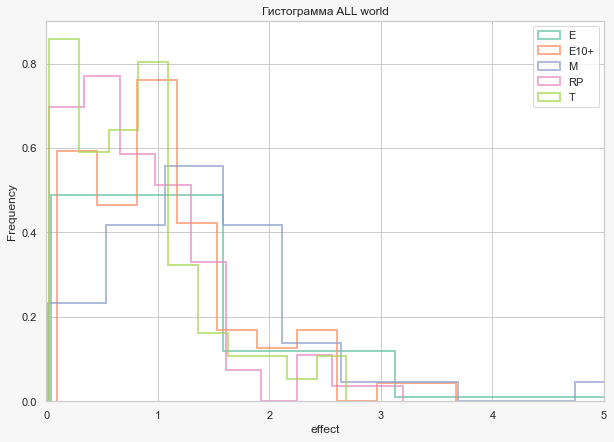

In [196]:
t = prep_tbl(act_df, param = 'total_sales')
show_hist_ratings(t, 'ALL world')

In [197]:
t

,platform,genre,rating,mean,count,sum,s1,c1,mean_all_ratings,effect
0,3DS,Action,E,0.608,18,10.940,34.040,116,0.293,2.071
1,3DS,Action,E10+,0.308,22,6.770,34.040,116,0.293,1.049
2,3DS,Action,M,0.315,2,0.630,34.040,116,0.293,1.073
3,3DS,Action,RP,0.218,66,14.360,34.040,116,0.293,0.741
4,3DS,Action,T,0.168,8,1.340,34.040,116,0.293,0.571
...,...,...,...,...,...,...,...,...,...,...
323,XOne,Sports,RP,0.035,2,0.070,26.740,38,0.704,0.050
324,XOne,Sports,T,0.347,7,2.430,26.740,38,0.704,0.493
325,XOne,Strategy,E,0.170,1,0.170,0.420,3,0.140,1.214
326,XOne,Strategy,RP,0.210,1,0.210,0.420,3,0.140,1.500


,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
E,61.000,1.796,3.053,0.000,0.266,1.000,1.657,20.407
E10+,62.000,1.451,1.398,0.000,0.621,0.997,1.899,8.000
M,40.000,1.547,0.977,0.000,0.859,1.406,2.021,3.975
RP,76.000,0.676,0.749,0.000,0.065,0.405,1.052,3.260
T,68.000,0.816,0.890,0.000,0.205,0.603,0.992,4.968


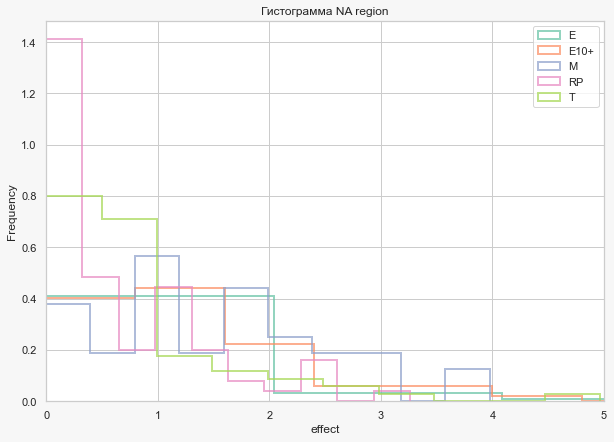

In [198]:
t = prep_tbl(act_df, param = 'na_sales')
show_hist_ratings(t, 'NA region')

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
E,65.000,2.567,6.429,0.000,0.695,1.091,2.000,50.414
E10+,66.000,1.326,1.332,0.000,0.480,1.000,1.648,7.414
M,40.000,1.381,0.864,0.000,0.919,1.244,1.964,3.125
RP,79.000,0.631,0.732,0.000,0.050,0.367,1.044,3.135
T,69.000,0.776,0.691,0.000,0.286,0.630,1.091,2.979


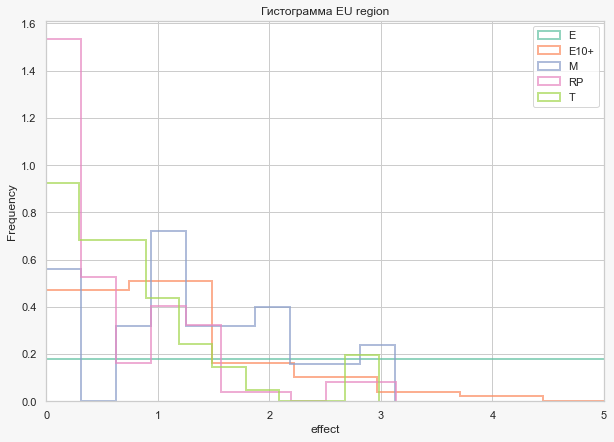

In [199]:
t = prep_tbl(act_df, param = 'eu_sales')
show_hist_ratings(t, 'EU region')

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
E,46.000,0.876,1.268,0.000,0.000,0.471,1.344,7.338
E10+,50.000,0.658,1.412,0.000,0.000,0.119,0.733,7.600
M,35.000,1.664,3.190,0.000,0.524,1.000,1.469,19.000
RP,71.000,1.178,0.850,0.000,0.781,1.000,1.455,4.500
T,55.000,0.773,0.818,0.000,0.000,0.591,1.197,3.130


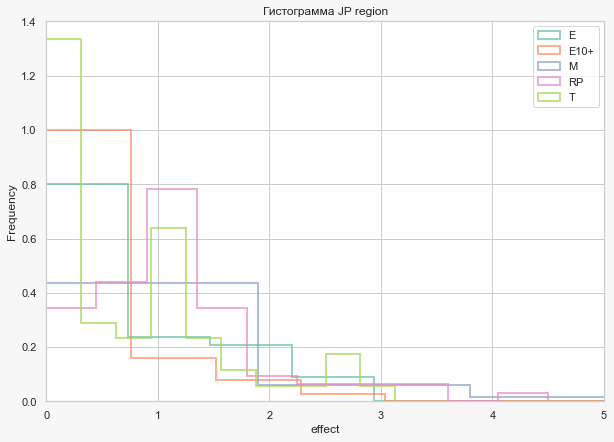

In [200]:
t = prep_tbl(act_df, param = 'jp_sales')
show_hist_ratings(t, 'JP region')

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
E,62.000,2.135,4.642,0.000,0.500,1.000,1.893,35.412
E10+,62.000,1.368,1.155,0.000,0.663,1.065,1.747,5.758
M,39.000,1.534,0.867,0.000,0.923,1.577,2.131,3.519
RP,76.000,0.653,0.742,0.000,0.075,0.360,1.014,3.167
T,66.000,0.788,0.836,0.000,0.161,0.624,0.988,4.400


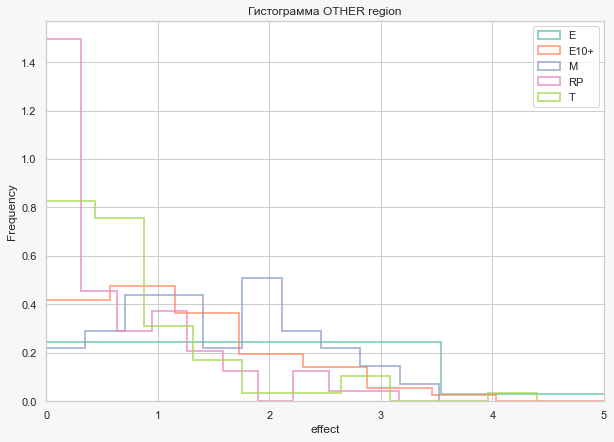

In [201]:
t = prep_tbl(act_df, param = 'other_sales')
show_hist_ratings(t, 'OTHER region')

**ВЫВОДЫ**

- Присвоение M (взрослый) рейтинга во всех регионах (в т.ч. JP) повышает средние продажи относительно игры на той же платформе и того же жанра.
- в NA/EU/other регионе E/E10+ не сильно влияют на продаваемость, а T снижает  продажи, игры без рейтинга (RP) имеют отрицательное влияние на продажи
- в JP регионе E/E10+ наоборот сильно снижают продаваемость, T снижает  продажи, но игры без рейтинга (RP) продаются на среднем уровне

Возможно в JP регионе есть дополнительные рейтинги или "народная молва", но факт в том, что игры без рейтинга там достаточно хорошо себя чувствуют


### ВЫВОДЫ по портрету пользователя

Американский игрок (NA регион) 
- от 17 лет, 
- любит играть или на PS4, X360, XOne,
- любит игры жанров Action, Shooter, Sports.

Европейский игрок (EU регион) 
- от 17 лет, 
- любит играть на PS4, PS3, XOne
- любит игры жанров Action, Shooter, Sports.

Японский игрок (JP регион) 
- от 13 лет и активно играет в игры без рейтинга
- любит играть на переносных платформах 3DS, PS3, PSV
- любит игры жанров Role-Playing, Action, Misc

## Шаг №5. Проверка гипотез

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [202]:
# Временный фрейм для тестирования гипотезы 1
t = act_df[act_df['platform'].isin(['XOne', 'PC'])].dropna(subset=['user_score'])

#### Анализ выбросов

На t-критерий сильно влияют выбросы. Посмотрим на распределения выборок и статистики

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PC,158.000,6.280,1.735,1.400,5.325,6.800,7.600,9.300
XOne,182.000,6.521,1.381,1.600,5.800,6.800,7.500,9.200


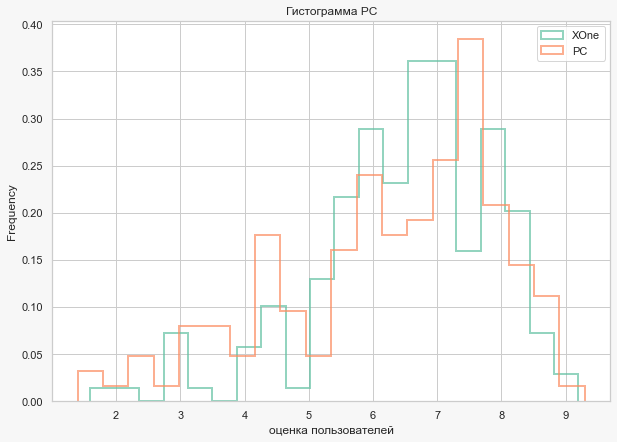

In [203]:
# Строим гистограмму и статистики
p = "XOne"
q = t.query('platform == @p').plot(kind='hist', y='user_score', 
            histtype='step',
            density=True,
            bins=20,
            alpha=0.7,
            linewidth=2,
            label=p,
            figsize=(10,7),
            #xlim=(0,5),
            title = "Гистограмма " + p
        )
p = "PC"
t.query('platform == @p').plot(kind='hist', y='user_score', 
            histtype='step',
            density=True,
            bins=20,
            alpha=0.7,
            linewidth=2,
            label=p,
            figsize=(10,7),
            ax=q,
            title = "Гистограмма " + p
        )
plt.xlabel('оценка пользователей')
plt.show

t.groupby('platform')['user_score'].describe()

----------------------------------------------------

Уберем все строки с выбросами

In [204]:
t = delete_outliers(t, 'platform', 'user_score')


platform XOne
bounds 1.5*IQR are:(3.25,9.20)
Удалено:8 (2.4%)

platform PC
bounds 1.5*IQR are:(1.91,9.30)
Удалено:2 (0.6%)


In [205]:
# После удаления выбросов статистики:
t.groupby('platform')['user_score'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PC,156.000,6.343,1.655,2.100,5.400,6.800,7.600,9.300
XOne,174.000,6.693,1.143,4.000,5.900,6.800,7.500,9.200


#### Формулирование гипотез 0/1

Будем использовать  t-критерий Стьюдента, так как сравниваемые выборки независимы между собой. <br>
Так как гистограммы слабо отличаются, то считаем дисперсии одинаковыми<br>
Из данных мы знаем, что средняя оценка пользователей PC лишь незначительно больше чем средняя оценка пользователей XOne, поэтому тестировать будем двустороннюю гипотезу.<br>
<br>
**H<sub>0</sub>**: средняя оценка пользователей PC равна средней оценке пользователей XOne<br>
**H<sub>1</sub>**: средняя оценка пользователей PC НЕ равна средней оценке пользователей XOne<br>
<br>
Уровень значимости alpha = 0.05

#### Тестирование гипотезы

In [206]:
results = st.ttest_ind(
    t.query('platform == "PC"')['user_score'], 
    t.query('platform == "XOne"')['user_score'], 
    equal_var = True
)

alpha = 0.05
print('p-значение: ', results.pvalue)
if alpha > results.pvalue:
    print('Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних')
else:
    print('Гипотеза H0 равенства средних не может быть отвергнута.')

p-значение:  0.024778453215193782
Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних


**ВЫВОД:** Гипотеза о равенстве средних оценок пользователей PC и XOne **не может быть отклонена**. 

### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные

In [207]:
# Временный фрейм для тестирования гипотезы 1
t = act_df[act_df['genre'].isin(['Action', 'Sports'])].dropna(subset=['user_score'])

#### Анализ выбросов

На t-критерий сильно влияют выбросы. Посмотрим на распределения выборок и статистики

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,391.000,6.837,1.331,2.000,6.300,7.100,7.800,9.100
Sports,160.000,5.238,1.783,0.200,4.100,5.500,6.500,8.800


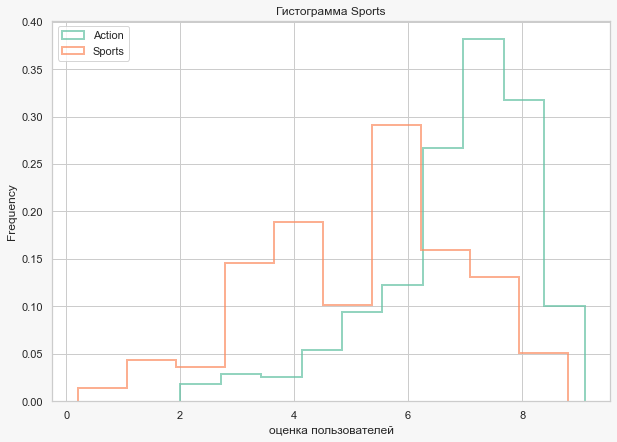

In [208]:
# Строим гистограмму и статистики
p = "Action"
q = t.query('genre == @p').plot(kind='hist', y='user_score', 
            histtype='step',
            density=True,
            #bins=15,
            alpha=0.7,
            linewidth=2,
            label=p,
            figsize=(10,7),
            #xlim=(0,5),
            title = "Гистограмма " + p
        )
p = "Sports"
t.query('genre == @p').plot(kind='hist', y='user_score', 
            histtype='step',
            density=True,
            #bins=15,
            alpha=0.7,
            linewidth=2,
            label=p,
            figsize=(10,7),
            ax=q,
            title = "Гистограмма " + p
        )
plt.xlabel('оценка пользователей')
plt.show

t.groupby('genre')['user_score'].describe()

----------------------------------------------------

Уберем все строки с выбросами

In [209]:
t = delete_outliers(t, 'genre', 'user_score')


genre Action
bounds 1.5*IQR are:(4.05,9.10)
Удалено:18 (3.3%)

genre Sports
bounds 1.5*IQR are:(0.50,8.80)
Удалено:1 (0.2%)


In [210]:
# После удаления выбросов статистики:
t.groupby('genre')['user_score'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,373.000,7.018,1.063,4.100,6.400,7.200,7.800,9.100
Sports,159.000,5.270,1.743,0.700,4.100,5.500,6.500,8.800


#### Формулирование гипотез 0/1

Будем использовать  t-критерий Стьюдента, так как сравниваемые выборки независимы между собой. <br>
Так как гистограммы сильно отличаются, то считаем дисперсии разными<br>
Из данных мы знаем, что средняя оценка Action  значительно больше чем средняя оценка Sports, поэтому тестировать будем одностороннюю гипотезу.<br>
<br>
**H<sub>0</sub>**: средняя оценка жанра Action равна средней оценке жанра Sports<br>
**H<sub>1</sub>**: средняя оценка  жанра Action больше средней оценки жанра Sports<br>
<br>
Уровень значимости alpha = 0.05

#### Тестирование гипотезы

In [211]:
results = st.ttest_ind(
    t.query('genre == "Action"')['user_score'], 
    t.query('genre == "Sports"')['user_score'], 
    equal_var = False
)

alpha = 0.05
print('p-значение: ', results.pvalue/2)
if alpha > results.pvalue/2:
    print('Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних')
else:
    print('Гипотеза H0 равенства средних не может быть отвергнута.')

p-значение:  4.0496001072550376e-25
Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних


**ВЫВОД:** Гипотеза о равенстве средних оценок жанра Action жанра Sports **должна быть отклонена**.<br>
Принимаем гипотезу, что средняя оценка  жанра Action **больше** средней оценки жанра Sports

## Общий вывод

  Изучив данные, оказалось, что данные в целом качественные, но достаточно много пропусков в рейтингах и оценках. вероятно при создании датасета не подгрузилась какая-то база с рейтингами, вероятно по JP региону
  
  При подготовке данных были проведены ряд процедур "хорошего стиля"
  - определили год выпуска для 130 из 269 пропусков
  - удалили 139 строк у которых не удалось определить год
  - выявили два дубликата и удалили их
  - заполнили пропуски rating на "RP"

По итогам предобработки осталось 16574 строк из 16715 исходных. Удалено 141 (0,8%) от исходного датасета
  
- Данные в датасете содержат большой период: с 1980 по 2016 год. 2016 год по всей видимости неполный и эти данные не могут быть использованы при прогнозировании на 2017 год.
- До 1990 года продажи игр были незначительными.
- Организация ESRB учреждена в 1994, поэтому много игр до 1994 не имеют рейтингов и оценок
- Платформы в среднем живут 8 лет. Самой долгоживущей является платформа PC
- С учетом времени жизни платформ, для прогноза на 2017 не стоит брать горизонт планирования более 3-4 лет
  

JP - регион своих вкусов, пользователи игнорируют популярные игры других регионов и предпочитают свои игры, которые в других регионах не популярны. Доля игр исключительных для региона к числу игр, продаваемых в регионе около 60-65%<br> 
NA - регион, который в среднем половину игр покупает, это самый серьезный рынок для игр.<br>
У NA и EU также есть свои специфичные игры, но доля исключительных игр около 9% от числа игр, продаваемых в регионе<br>
А регион Other вообще почти не имеет специфичных игр и играет в "чужие" игры, причем доля этого региона в доле продаж таких игр почти никогда не превышает 30%. Можно сказать несущественный и не специфичный регион.


За последние 3 года из платформ безусловным лидером является PS4, далее идет XOne, которая последние пару лет опережает PS3 и 3DS, а еще почти в 2 раза каждая игра в среднем больше продается.<br>
Далее 3DS, который сопоставим с PS3 по общим продажам, но имеет преимущество в виде пары супер-популярных игр. С другой стороны, у 3DS самый низкий IQR и Q3, что говорит о высокой доле неудач с играми. X360 примечательна тем, что после PS4, XOne имеет самую высокую медиану, что говорит о высоком шансе запустить успешные игры, пусть и не супер-бестселлер, но успешные.
<br>Основной акцент стоит делать на популярных платформах PS4, XOne
  
- Влияние на продажи оценок критиков умеренное для всех регионов, причем для высоких оценок (выше 60-70) влияние сильнее, а низкие оценки почти не влияют на продажи
- Влияние на продажи оценок пользователей несущественное
 
**Портрет пользователя**<br>
Американский игрок (NA регион) 
- предпочитает рейтинг М (от 17 лет), 
- любит играть или на PS4, X360, XOne,
- любит игры жанров Action, Shooter, Sports.

Европейский игрок (EU регион) 
- предпочитает рейтинг М (от 17 лет), 
- любит играть на PS4, PS3, XOne
- любит игры жанров Action, Shooter, Sports.

Японский игрок (JP регион) 
- предпочитает рейтинг Т (от 13 лет) и активно играет в игры без рейтинга
- любит играть на переносных платформах 3DS, PS3, PSV
- любит игры жанров Role-Playing, Action, Misc

В среднем присвоение M (взрослый) рейтинга во всех регионах (в т.ч. JP) повышает средние продажи относительно игры на той же платформе и того же жанра. Но разброс велик достаточно, поэтому выбрав платформу или жанр стоит более внимательно изучить этот эффект.

Путем тестирования гипотезы №1, установили, что гипотеза о равенстве средних оценок пользователей PC и XOne **не может быть отклонена**

Путем тестирования гипотезы №2, установили, что гипотеза о равенстве средних оценок жанра Action жанра Sports должна быть отклонена. Приняли альтернативную гипотезу, что средняя оценка жанра Action **больше** средней оценки жанра Sports

## Рекомендации

1. Изучить причины большого числа пропусков рейтингов и оценок для игр. Возможно это устранимо хотя бы для современных игр
2. После 2009-2010 годов произошло сильное сокращение продаж игр на платформах. Вероятно это связано с появлением смартфонов (Apple в 2007 сделали iPhone) и миграцией игроков на мобильные платформы. По всей видимости в данных нет мобильных платформ. Стоит провести анализ и по ним тоже.
3. Европа похожа на Америку, да и на остальные регионы, а вот Япония (JP) существенно отличается. Нужно это иметь в виду, при разработке стратегии развития. Тут нужно быть аккуратными.
